## MA23M002 - ABHINAV T K <br> CS6910 - Assignment 1

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [12]:
class NeuralNetwork:
  def __init__(self, x, y, x_test, y_test):
    self.x = x
    self.y = y
    self.x_test = x_test
    self.y_test = y_test

    self.c = len(np.unique(y))        # no. of classes

     # Class names - the index of the class names corresponds to the class label
    self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

  def preprocess(self):
    # change shape
    self.x = self.x.reshape(self.x.shape[0], -1)
    self.inp_features = self.x.shape[1]    # no. of input features

    self.x_test = self.x_test.reshape(self.x_test.shape[0], -1)
    # normalize data
    self.x = self.x/255.0
    self.x_test = self.x_test/255.0

  def split_data(self):
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x, self.y, test_size=0.1,random_state=42)

  def print_data_details(self):
    print("Total no. of classes = ", self.c)
    print("The class names are: ", self.classes)
    print("Number of input features = ", self.inp_features)

    # training samples size
    self.m = self.x_train.shape[0]
    print("Training samples = ", self.m)

    # validation samples size
    self.m_val = self.x_val.shape[0]
    print("Validation samples = ", self.m_val)

    # test samples size
    self.m_test = self.x_test.shape[0]
    print("Test samples = ", self.m_test)

  def one_hot_encod(self):
    self.y_train_encoded = np.eye(np.max(self.y_train) + 1)[self.y_train].T
    self.y_val_encoded = np.eye(np.max(self.y_val) + 1)[self.y_val].T
    self.y_test_encoded = np.eye(np.max(self.y_test) + 1)[self.y_test].T

  # Initializing parameters W and b
  def initialize_parameters(self, nn_layers, weight_init="random"):
    '''
    nn_layers: a list containing the number of neurons of each layer - where each layer no. is the index of the list
    '''
    np.random.seed(42)
    parameters = {}                         # dictionary to hold weights and biases of each layer
    prev_v = {}
    for i in range(1, len(nn_layers)):
      if weight_init == "xavier":
        parameters["W"+str(i)] = np.random.randn(nn_layers[i],nn_layers[i-1])*np.sqrt(2/(nn_layers[i]+nn_layers[i-1]))
      elif weight_init == "random":
        parameters["W"+str(i)] = np.random.randn(nn_layers[i], nn_layers[i-1])
      parameters["b"+str(i)] = np.zeros((nn_layers[i], 1))
      prev_v["W"+str(i)] = np.zeros((nn_layers[i], nn_layers[i-1]))
      prev_v["b"+str(i)] = np.zeros((nn_layers[i], 1))
    return parameters, prev_v

  # Activation functions
  def relu(self, x):
    return np.maximum(0,x)

  def tanh(self, x):
      return np.tanh(x)

  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

  def softmax(self, x):
      return np.exp(x) / np.sum(np.exp(x), axis=0)

  # Derivatives of activation functions

  def sigmoid_grad(self, x):
      return self.sigmoid(x) * (1-self.sigmoid(x))

  def relu_grad(self, x):
      return 1*(x>0)

  def tanh_grad(self, x):
      return (1 - (np.tanh(x)**2))

  def softmax_grad(self, x):
      return self.softmax(x) * (1-self.softmax(x))


 # Forward propagation
  def forward_propagation(self, x, nn_layers, parameters, act_fn):

    l = len(nn_layers)  # No. of neural network layers, including input and output layers

    a = {}              # dictionary to hold hidden layer (pre-activation)
    h = {}              # dictionary to hold hidden layer (activation)

    h[0] = x.T  # input layer

    for i in range(1, l-1):
      W = parameters["W"+str(i)]        # weights of hidden layer i
      b = parameters["b"+str(i)]        # bias of hidden layer i

      a[i] = np.matmul(W,h[i-1]) + b

      # activation for hidden layers
      if act_fn == 'sigmoid':
        h[i] = self.sigmoid(a[i])
      elif act_fn == 'relu':
        h[i] = self.relu(a[i])
      elif act_fn == 'tanh':
        h[i] = self.tanh(a[i])

    # output layer
    W = parameters["W"+str(l-1)]    # weights of hidden layer i
    b = parameters["b"+str(l-1)]    # bias of hidden layer i

    a[l-1] = np.matmul(W,h[l-2]) + b          # activation function for output layer

    y_hat = self.softmax(a[l-1])
    return y_hat, h, a                # Returns y_hat, h, a

  # Backpropagation
  def back_propagation(self, y_hat, y, h, a, nn_layers, parameters, act_fn, batch_size, l2_reg):
    l = len(nn_layers)
    grads = {}            # dictionary to store gradient of loss function wrt parameters and hidden layer neurons

    # Computing gradient wrt output layer
    grads["grada"+str(l-1)] = y_hat - y

    for i in range(l-1,0,-1):

      grads["gradW" + str(i)] = (1/batch_size)*(np.dot(grads["grada" + str(i)], h[i-1].T) + l2_reg*parameters["W"+str(i)])
      grads["gradb" + str(i)] = (1/batch_size)*np.sum(grads["grada" + str(i)], axis=1, keepdims=True)
      if i>1:
        if act_fn == 'sigmoid':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.sigmoid_grad(a[i-1])   # Computing gradients wrt hidden layers
        elif act_fn == 'relu':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.relu_grad(a[i-1])
        elif act_fn == 'tanh':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.tanh_grad(a[i-1])
    return grads

  # Update parameter based on different optimizers
  def param_update_sgd(self, parameters, grads , lr):
    l = len(parameters) // 2    # no. of hidden layers + outer layer
    for i in range(1, l + 1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - lr * grads["gradW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - lr * grads["gradb" + str(i)]
    return parameters

  def param_update_momentum(self, parameters, grads , lr, beta, prev_v):
    l = len(parameters) // 2     # no. of hidden layers + outer layer
    eta = 1.0
    for i in range(1, l + 1):
      prev_v["W"+str(i)] = beta*prev_v["W"+str(i)] + eta*grads["gradW" + str(i)]
      prev_v["b"+str(i)] = beta*prev_v["b"+str(i)] + eta*grads["gradb" + str(i)]

      parameters["W" + str(i)] = parameters["W" + str(i)] - lr*prev_v["W"+str(i)]
      parameters["b" + str(i)] = parameters["b" + str(i)] - lr*prev_v["b"+str(i)]

    return parameters, prev_v

  def param_update_nesterov(self, parameters, grads , lr, beta, prev_v):
    l = len(parameters) // 2     # no. of hidden layers + outer layer
    eta = 1.0
    for i in range(1, l + 1):
      prev_v["W"+str(i)] = beta*prev_v["W"+str(i)] + eta*grads["gradW" + str(i)]
      prev_v["b"+str(i)] = beta*prev_v["b"+str(i)] + eta*grads["gradb" + str(i)]

      parameters["W" + str(i)] = parameters["W" + str(i)] - lr*prev_v["W"+str(i)]
      parameters["b" + str(i)] = parameters["b" + str(i)] - lr*prev_v["b"+str(i)]
    return parameters, prev_v

  def compute_loss(self, y, y_hat, batch_size):
    loss_val = (-1/batch_size)*(np.sum(np.multiply(y, np.log(y_hat))))
    return loss_val

  # Plotting function
  def plot_loss_curve(self, training_loss, validation_loss):
      """
      Plot the training and validation loss curves.
      """
      n1 = len(training_loss)
      n2 = len(validation_loss)
      plt.plot(list(range(n1)), training_loss, 'b', label="Training Loss")
      plt.plot(list(range(n2)), validation_loss, 'r', label="Validation Loss")

      # Adding title and labels
      plt.title("Training and Validation Loss vs Epochs")
      plt.xlabel("# Epochs")
      plt.ylabel("Loss")

      plt.grid()
      plt.legend()
      plt.show()

  def train_model(self, epochs = 10, num_hidden_layers = 3, num_neurons = 128, learning_rate = 0.001, act_fn = 'tanh',
                    weight_init = 'random', optimizer = 'momentum',  batch_size = 512, l2_reg = 0.5):

    '''
    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, relu
    '''

    nn_layers = [self.inp_features] + [num_neurons]*num_hidden_layers + [self.c]
    parameters, prev_v = self.initialize_parameters(nn_layers, weight_init)
    params_nesterov = parameters.copy()
    l = len(parameters) // 2                              # no. of hidden layers + outer layer
    beta = 0.9                                            # decay rate
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
      if optimizer == 'sgd':
        batch_size = 1
      for i in range(0, self.x_train.shape[0], batch_size):
        batch_sz = min(batch_size, self.x_train.shape[0] - i)
        if optimizer == 'nesterov':
          for j in range(1, l+1):
            params_nesterov["W"+str(j)] = parameters["W"+str(j)] - beta*prev_v["W"+str(j)]
            params_nesterov["b"+str(j)] = parameters["b"+str(j)] - beta*prev_v["b"+str(j)]
          # calculating grads for look ahead
          y_hat, h, a = self.forward_propagation(self.x_train[i:i+batch_sz,:], nn_layers, params_nesterov, act_fn)
          grads = self.back_propagation(y_hat, self.y_train_encoded[:,i:i+batch_sz], h, a, nn_layers, params_nesterov, act_fn, batch_sz, l2_reg)
          # parameter update for nesterove using grad calculated by look ahead
          parameters, prev_v = self.param_update_momentum(parameters, grads , lr, beta, prev_v)

        else:
          y_hat, h, a = self.forward_propagation(self.x_train[i:i+batch_sz,:], nn_layers, parameters, act_fn)
          grads = self.back_propagation(y_hat, self.y_train_encoded[:,i:i+batch_sz], h, a, nn_layers, parameters, act_fn, batch_sz, l2_reg)
          if optimizer == 'sgd':
            parameters = self.param_update_sgd(parameters, grads, lr)
          elif optimizer == 'momentum':
            parameters, prev_v = self.param_update_momentum(parameters, grads , lr, beta, prev_v)

      # model evaluation
      y_hat, _, _ = self.forward_propagation(self.x_train, nn_layers, parameters, act_fn)
      cost = self.compute_loss(self.y_train_encoded, y_hat, 54000)
      training_loss.append(cost)

      #one-hot encoding y_hat
      y_hat_encoded = np.zeros_like(y_hat)
      for i in range(y_hat.shape[1]):
        max_index = np.argmax(y_hat[:, i])
        y_hat_encoded[max_index, i] = 1
      accuracy = np.mean(y_hat_encoded == self.y_train_encoded)

      # loss for the validation set
      y_val_hat, _, _ = self.forward_propagation(self.x_val, nn_layers, parameters, act_fn)
      val_cost = self.compute_loss(self.y_val_encoded, y_val_hat, 6000)
      validation_loss.append(val_cost)
      #one-hot encoding y_val_hat
      y_val_hat_encoded = np.zeros_like(y_val_hat)
      for i in range(y_val_hat.shape[1]):
        max_index = np.argmax(y_val_hat[:, i])
        y_val_hat_encoded[max_index, i] = 1
      val_accuracy = np.mean(y_val_hat_encoded == self.y_val_encoded)

      print("Epochs = ", epoch, "\tTraining cost:", cost, "\tAccuracy:", accuracy, "\t Validation Accuracy:", val_accuracy)

    self.plot_loss_curve(training_loss, validation_loss)
    return parameters

Total no. of classes =  10
The class names are:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of input features =  784
Training samples =  54000
Validation samples =  6000
Test samples =  10000
Epochs =  0 	Training cost: 2.758173056037107 	Accuracy: 0.9112444444444444 	 Validation Accuracy: 0.9097
Epochs =  1 	Training cost: 1.7099963857651028 	Accuracy: 0.9198407407407407 	 Validation Accuracy: 0.9158333333333334
Epochs =  2 	Training cost: 1.3752148239094277 	Accuracy: 0.9272222222222222 	 Validation Accuracy: 0.9248666666666666
Epochs =  3 	Training cost: 1.1920890928963515 	Accuracy: 0.9317740740740741 	 Validation Accuracy: 0.9286333333333333
Epochs =  4 	Training cost: 1.0746464397647673 	Accuracy: 0.934625925925926 	 Validation Accuracy: 0.9309
Epochs =  5 	Training cost: 0.9890711356828408 	Accuracy: 0.9374148148148148 	 Validation Accuracy: 0.9329333333333333
Epochs =  6 	Training cost: 0.9248335587587962 	A

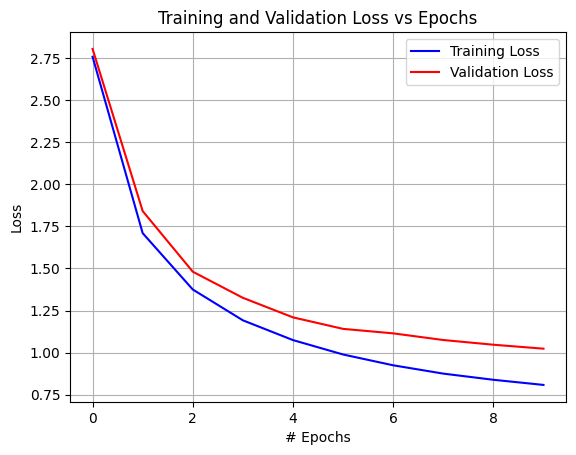

In [13]:
if __name__=='__main__':
  iter = 0
  epochs = 10
  lr = 0.01 # learning rate
  batch_size = 64 #x_train, y_train, x_val, y_val,
  # Load the Fashion MNIST dataset
  (x, y), (x_test, y_test) = fashion_mnist.load_data()
  nn = NeuralNetwork(x, y, x_test, y_test)
  nn.preprocess()
  nn.split_data()
  nn.print_data_details()
  nn.one_hot_encod()
  parameters = nn.train_model()

# Using wandb for hyperparameter tuning

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [ ]:
def run_model_wandb(x_train, y_train, x_val, y_val, epochs = 10, num_hidden_layers = 3, num_neurons = 128, learning_rate = 0.001, act_fn = 'tanh',
                    weight_init = 'random', optimizer = 'momentum',  batch_size = 512, l2_reg = 0):
  '''
  number of epochs: 5, 10
  number of hidden layers: 3, 4, 5
  size of every hidden layer: 32, 64, 128
  weight decay (L2 regularisation): 0, 0.0005, 0.5
  learning rate: 1e-3, 1e-4
  optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
  batch size: 16, 32, 64
  weight initialisation: random, Xavier
  activation functions: sigmoid, tanh, relu
  '''

  nn_layers = [inp_features] + [num_neurons]*num_hidden_layers + [c]
  parameters, prev_v = initialize_parameters(nn_layers, weight_init)
  params_nesterov = parameters.copy()
  l = len(parameters) // 2                              # no. of hidden layers + outer layer
  beta = 0.9                                            # decay rate
  training_loss = []
  validation_loss = []
  for epoch in range(epochs):
    if optimizer == 'sgd':
      batch_size = 1
    for i in range(0, x_train.shape[0], batch_size):
      batch_sz = min(batch_size, x_train.shape[0] - i)
      if optimizer == 'nesterov':
        for j in range(1, l+1):
          params_nesterov["W"+str(j)] = parameters["W"+str(j)] - beta*prev_v["W"+str(j)]
          params_nesterov["b"+str(j)] = parameters["b"+str(j)] - beta*prev_v["b"+str(j)]
        # calculating grads for look ahead
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, params_nesterov, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, params_nesterov, act_fn, batch_sz, l2_reg)
        # parameter update for nesterove using grad calculated by look ahead
        parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

      else:
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, parameters, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, parameters, act_fn, batch_sz, l2_reg)
        if optimizer == 'sgd':
          parameters = param_update_sgd(parameters, grads, lr)
        elif optimizer == 'momentum':
          parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

    # model evaluation
    y_hat, _, _ = forward_propagation(x_train, nn_layers, parameters, act_fn)
    cost = compute_loss(y_train, y_hat, 54000)
    training_loss.append(cost)

    #one-hot encoding y_hat
    y_hat_encoded = np.zeros_like(y_hat)
    for i in range(y_hat.shape[1]):
      max_index = np.argmax(y_hat[:, i])
      y_hat_encoded[max_index, i] = 1
    accuracy = np.mean(y_hat_encoded == y_train)
    wandb.log({'train loss': cost, 'train accuracy': accuracy * 100, 'epoch': epoch+1})

    # loss for the validation set
    y_val_hat, _, _ = forward_propagation(x_val, nn_layers, parameters, act_fn)
    val_cost = compute_loss(y_val, y_val_hat, 6000)
    validation_loss.append(val_cost)
    #one-hot encoding y_val_hat
    y_val_hat_encoded = np.zeros_like(y_val_hat)
    for i in range(y_val_hat.shape[1]):
      max_index = np.argmax(y_val_hat[:, i])
      y_val_hat_encoded[max_index, i] = 1
    val_accuracy = np.mean(y_val_hat_encoded == y_val)
    wandb.log({'val_accuracy': val_accuracy * 100})

    print("Epochs = ", epoch, "\tTraining cost:", cost, "\tAccuracy:", accuracy, "\t Validation Accuracy:", val_accuracy)
  #l1 = [y_train, y_hat, training_loss, y_val, y_val_hat, validation_loss]
  #plot_loss_curve(training_loss, validation_loss)
  return parameters

In [ ]:
wandb.login(key='4966bf774ea7ce7b47a6e7360b1fad927ece6f1c')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

epochs = 10, num_hidden_layers = 1, num_neurons = 128, learning_rate = 0.001, act_fn = 'sigmoid', weight_init = 'xavier',
                optimizer = 'sgd',  batch_size = 512, wt_decay_l2 = 0 <br>
x_train, y_train, epochs = 10, num_hidden_layers = 3, num_neurons = 128, learning_rate = 0.001, act_fn = 'tanh', weight_init = 'xavier',
                optimizer = 'sgd',  batch_size = 512, wt_decay_l2 = 0

In [ ]:
# config file
sweep_config = {
    'method': 'grid',
    'name' : 'sweep test2',

    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {

        'epochs': {
            'values': [5, 10]
        },
        'num_hidden_layers':{
            'values': [3, 4, 5]
        },
         'num_neurons':{
            'values':[32, 64, 128]
        },
        'learning_rate':{
            'values':[0.001, 0.0001]
        },
        'act_fn': {
            'values': ['sigmoid', 'tanh', 'relu']
        },
        'optimizer': {
            'values': ['momentum', 'sgd', 'nesterov']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'l2_reg':{
            'values': [0, 0.0005, 0.5]
        }
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project='wandb-basics')

Create sweep with ID: dbirz66w
Sweep URL: https://wandb.ai/abhinavtk/wandb-basics/sweeps/dbirz66w


In [ ]:
def main():
  '''
  WandB calls main function each time with differnet combination.

  We can retrive the same and use the same values for our hypermeters.

  '''

  with wandb.init() as run:
    run_name="-hl_"+str(wandb.config.num_hidden_layers)+"-hs_"+str(wandb.config.num_neurons)+"-ac_"+  \
    wandb.config.act_fn+"-opt_"+wandb.config.optimizer
    wandb.run.name = run_name
    #obj=NN(wandb.config['num_layers'],wandb.config['hidden_size'])

    # Local variables, values obtained from wandb config
    params = run_model_wandb(x_train, y_train_encoded, x_val, y_val_encoded, epochs = wandb.config.epochs,
                             num_hidden_layers = wandb.config.num_hidden_layers, num_neurons = wandb.config.num_neurons,
                             learning_rate = wandb.config.learning_rate, act_fn = wandb.config.act_fn, weight_init = wandb.config.weight_init,
                             optimizer = wandb.config.optimizer,  batch_size = wandb.config.batch_size, l2_reg = wandb.config.l2_reg)

wandb.agent(sweep_id, function = main, count = 120) # calls main function for count number of times.
wandb.finish()


wandb: Agent Starting Run: duw2cj2j with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: Currently logged in as: abhinavtk. Use `wandb login --relogin` to force relogin


Epochs =  0 	Training cost: 0.6798852486428703 	Accuracy: 0.950462962962963 	 Validation Accuracy: 0.9493666666666667
Epochs =  1 	Training cost: 0.5876061330516603 	Accuracy: 0.957137037037037 	 Validation Accuracy: 0.9564333333333334
Epochs =  2 	Training cost: 0.5357297099806341 	Accuracy: 0.9613074074074074 	 Validation Accuracy: 0.9596333333333333
Epochs =  3 	Training cost: 0.5042555689301942 	Accuracy: 0.9637962962962963 	 Validation Accuracy: 0.9619
Epochs =  4 	Training cost: 0.4824716357441618 	Accuracy: 0.9651851851851851 	 Validation Accuracy: 0.963


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.51852
train loss,0.48247
val_accuracy,96.3


wandb: Agent Starting Run: 8ht9k6ed with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.7258955906218043 	Accuracy: 0.948462962962963 	 Validation Accuracy: 0.9472666666666667
Epochs =  1 	Training cost: 0.5345641886726237 	Accuracy: 0.9611296296296297 	 Validation Accuracy: 0.9598
Epochs =  2 	Training cost: 0.46305040708944406 	Accuracy: 0.9669851851851852 	 Validation Accuracy: 0.9659666666666666
Epochs =  3 	Training cost: 0.424156257747168 	Accuracy: 0.9697259259259259 	 Validation Accuracy: 0.9691666666666666
Epochs =  4 	Training cost: 0.39963917471688437 	Accuracy: 0.9713555555555555 	 Validation Accuracy: 0.9701333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.13556
train loss,0.39964
val_accuracy,97.01333


wandb: Agent Starting Run: 5i8iwcwt with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6350250110952931 	Accuracy: 0.9531111111111111 	 Validation Accuracy: 0.9518666666666666
Epochs =  1 	Training cost: 0.542695194319897 	Accuracy: 0.9605 	 Validation Accuracy: 0.9587333333333333
Epochs =  2 	Training cost: 0.500448510489709 	Accuracy: 0.9636259259259259 	 Validation Accuracy: 0.9619
Epochs =  3 	Training cost: 0.4750486525937878 	Accuracy: 0.9655074074074074 	 Validation Accuracy: 0.9644666666666667
Epochs =  4 	Training cost: 0.4525447056814673 	Accuracy: 0.9673444444444445 	 Validation Accuracy: 0.9654666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.73444
train loss,0.45254
val_accuracy,96.54667


wandb: Agent Starting Run: 46akkf80 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6110572009205933 	Accuracy: 0.9534962962962963 	 Validation Accuracy: 0.9518666666666666
Epochs =  1 	Training cost: 0.48245629679655644 	Accuracy: 0.965362962962963 	 Validation Accuracy: 0.9641666666666666
Epochs =  2 	Training cost: 0.41308256088615686 	Accuracy: 0.970437037037037 	 Validation Accuracy: 0.9698666666666667
Epochs =  3 	Training cost: 0.3822160319951204 	Accuracy: 0.9726222222222223 	 Validation Accuracy: 0.9712
Epochs =  4 	Training cost: 0.3620183127973095 	Accuracy: 0.9739851851851852 	 Validation Accuracy: 0.9722


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.39852
train loss,0.36202
val_accuracy,97.22


wandb: Agent Starting Run: rm6jagfc with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6889024479789182 	Accuracy: 0.9480814814814815 	 Validation Accuracy: 0.9467333333333333
Epochs =  1 	Training cost: 0.6074509991177173 	Accuracy: 0.955062962962963 	 Validation Accuracy: 0.9539666666666666
Epochs =  2 	Training cost: 0.5570007520187733 	Accuracy: 0.9597407407407408 	 Validation Accuracy: 0.9584
Epochs =  3 	Training cost: 0.5222425985079612 	Accuracy: 0.962825925925926 	 Validation Accuracy: 0.9607333333333333
Epochs =  4 	Training cost: 0.49814506664948494 	Accuracy: 0.9647777777777777 	 Validation Accuracy: 0.9622


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.47778
train loss,0.49815
val_accuracy,96.22


wandb: Agent Starting Run: h9xywnou with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.832282657838881 	Accuracy: 0.9362 	 Validation Accuracy: 0.9337666666666666
Epochs =  1 	Training cost: 0.6517597773843251 	Accuracy: 0.9499888888888889 	 Validation Accuracy: 0.9486
Epochs =  2 	Training cost: 0.57206250371484 	Accuracy: 0.9572592592592593 	 Validation Accuracy: 0.9559
Epochs =  3 	Training cost: 0.5162334824380697 	Accuracy: 0.9609037037037037 	 Validation Accuracy: 0.9601
Epochs =  4 	Training cost: 0.47505774831747194 	Accuracy: 0.9660481481481481 	 Validation Accuracy: 0.9644666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.60481
train loss,0.47506
val_accuracy,96.44667


wandb: Agent Starting Run: hgw7uxdi with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6153994346346077 	Accuracy: 0.9555555555555556 	 Validation Accuracy: 0.9531
Epochs =  1 	Training cost: 0.540601455474236 	Accuracy: 0.9608888888888889 	 Validation Accuracy: 0.9581333333333333
Epochs =  2 	Training cost: 0.5004651876195424 	Accuracy: 0.9639555555555556 	 Validation Accuracy: 0.9606666666666667
Epochs =  3 	Training cost: 0.4728941332120549 	Accuracy: 0.9661148148148148 	 Validation Accuracy: 0.9624
Epochs =  4 	Training cost: 0.452095166513427 	Accuracy: 0.9675925925925926 	 Validation Accuracy: 0.9641666666666666


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.75926
train loss,0.4521
val_accuracy,96.41667


wandb: Agent Starting Run: y1nzqk2z with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6600199759347273 	Accuracy: 0.9523259259259259 	 Validation Accuracy: 0.9515
Epochs =  1 	Training cost: 0.4911112093485048 	Accuracy: 0.965437037037037 	 Validation Accuracy: 0.9649
Epochs =  2 	Training cost: 0.4248801405973892 	Accuracy: 0.9698148148148148 	 Validation Accuracy: 0.9692
Epochs =  3 	Training cost: 0.3893038624999575 	Accuracy: 0.9723592592592593 	 Validation Accuracy: 0.9718
Epochs =  4 	Training cost: 0.36666403113112034 	Accuracy: 0.9737962962962963 	 Validation Accuracy: 0.9723333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,97.37963
train loss,0.36666
val_accuracy,97.23333


wandb: Agent Starting Run: exm6wr0j with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6064462719976982 	Accuracy: 0.9549407407407408 	 Validation Accuracy: 0.9522333333333334
Epochs =  1 	Training cost: 0.527355500376452 	Accuracy: 0.9611185185185185 	 Validation Accuracy: 0.9576666666666667
Epochs =  2 	Training cost: 0.4841242940176767 	Accuracy: 0.9643 	 Validation Accuracy: 0.9612666666666667
Epochs =  3 	Training cost: 0.4525534196930343 	Accuracy: 0.9668666666666667 	 Validation Accuracy: 0.9634666666666667
Epochs =  4 	Training cost: 0.42846099423721534 	Accuracy: 0.968837037037037 	 Validation Accuracy: 0.9656


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.8837
train loss,0.42846
val_accuracy,96.56


wandb: Agent Starting Run: 6zsisxs8 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.5723956138426219 	Accuracy: 0.9585777777777778 	 Validation Accuracy: 0.9574666666666667
Epochs =  1 	Training cost: 0.43049570927462677 	Accuracy: 0.9699703703703704 	 Validation Accuracy: 0.9697333333333333
Epochs =  2 	Training cost: 0.38046467479032275 	Accuracy: 0.973 	 Validation Accuracy: 0.9726666666666667
Epochs =  3 	Training cost: 0.3537268097030486 	Accuracy: 0.9746703703703704 	 Validation Accuracy: 0.9735333333333334
Epochs =  4 	Training cost: 0.3361262629184455 	Accuracy: 0.9757370370370371 	 Validation Accuracy: 0.9741333333333333


epoch,▁▃▅▆█
train accuracy,▁▆▇██
train loss,█▄▂▂▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,97.5737
train loss,0.33613
val_accuracy,97.41333


wandb: Agent Starting Run: tu7fow6e with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6370908959655276 	Accuracy: 0.9532814814814815 	 Validation Accuracy: 0.9516666666666667
Epochs =  1 	Training cost: 0.5576424008158053 	Accuracy: 0.9596888888888889 	 Validation Accuracy: 0.9578666666666666
Epochs =  2 	Training cost: 0.5156200639549601 	Accuracy: 0.9628407407407408 	 Validation Accuracy: 0.9605666666666667
Epochs =  3 	Training cost: 0.48575050845749984 	Accuracy: 0.9648111111111111 	 Validation Accuracy: 0.9620333333333333
Epochs =  4 	Training cost: 0.4640525850192897 	Accuracy: 0.9661814814814815 	 Validation Accuracy: 0.9635333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.61815
train loss,0.46405
val_accuracy,96.35333


wandb: Agent Starting Run: ykt1t2ti with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8393703648251916 	Accuracy: 0.9361666666666667 	 Validation Accuracy: 0.9344
Epochs =  1 	Training cost: 0.6452003406772494 	Accuracy: 0.9517222222222222 	 Validation Accuracy: 0.9490666666666666
Epochs =  2 	Training cost: 0.5714172671669017 	Accuracy: 0.9571888888888889 	 Validation Accuracy: 0.955
Epochs =  3 	Training cost: 0.5227510632872654 	Accuracy: 0.9602888888888889 	 Validation Accuracy: 0.9584
Epochs =  4 	Training cost: 0.48795707690247675 	Accuracy: 0.9636370370370371 	 Validation Accuracy: 0.9614333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.3637
train loss,0.48796
val_accuracy,96.14333


wandb: Agent Starting Run: s263pk4v with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5980353402644303 	Accuracy: 0.9561518518518518 	 Validation Accuracy: 0.9546
Epochs =  1 	Training cost: 0.5247138734444802 	Accuracy: 0.9619333333333333 	 Validation Accuracy: 0.9586666666666667
Epochs =  2 	Training cost: 0.47994629428105806 	Accuracy: 0.9650555555555556 	 Validation Accuracy: 0.9614
Epochs =  3 	Training cost: 0.45005992956751595 	Accuracy: 0.9672185185185185 	 Validation Accuracy: 0.9629333333333333
Epochs =  4 	Training cost: 0.4298321514649404 	Accuracy: 0.9688518518518519 	 Validation Accuracy: 0.9648333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.88519
train loss,0.42983
val_accuracy,96.48333


wandb: Agent Starting Run: 3bszyaqd with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6078228243611296 	Accuracy: 0.9567074074074075 	 Validation Accuracy: 0.9561
Epochs =  1 	Training cost: 0.4667447761916205 	Accuracy: 0.9667444444444444 	 Validation Accuracy: 0.9660333333333333
Epochs =  2 	Training cost: 0.4132672042629415 	Accuracy: 0.9708222222222223 	 Validation Accuracy: 0.9703333333333334
Epochs =  3 	Training cost: 0.3833808533261399 	Accuracy: 0.9727111111111111 	 Validation Accuracy: 0.9720333333333333
Epochs =  4 	Training cost: 0.36221981966497435 	Accuracy: 0.9740222222222222 	 Validation Accuracy: 0.9724666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.40222
train loss,0.36222
val_accuracy,97.24667


wandb: Agent Starting Run: zj057y4w with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5724075833851817 	Accuracy: 0.9580962962962963 	 Validation Accuracy: 0.9556
Epochs =  1 	Training cost: 0.5072064773124637 	Accuracy: 0.9631111111111111 	 Validation Accuracy: 0.9594
Epochs =  2 	Training cost: 0.4564126443391411 	Accuracy: 0.9663888888888889 	 Validation Accuracy: 0.963
Epochs =  3 	Training cost: 0.43385163173134234 	Accuracy: 0.9682888888888889 	 Validation Accuracy: 0.9644
Epochs =  4 	Training cost: 0.4069634414575903 	Accuracy: 0.9701296296296297 	 Validation Accuracy: 0.9663666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
epoch,5
train accuracy,97.01296
train loss,0.40696
val_accuracy,96.63667


wandb: Agent Starting Run: 7jbcwbs6 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.542508139481322 	Accuracy: 0.961 	 Validation Accuracy: 0.9603
Epochs =  1 	Training cost: 0.43441944443450836 	Accuracy: 0.9693814814814815 	 Validation Accuracy: 0.9687
Epochs =  2 	Training cost: 0.3914055334937679 	Accuracy: 0.9720185185185185 	 Validation Accuracy: 0.9711666666666666
Epochs =  3 	Training cost: 0.3653268500439707 	Accuracy: 0.973674074074074 	 Validation Accuracy: 0.9724333333333334
Epochs =  4 	Training cost: 0.3467440377436171 	Accuracy: 0.9749407407407408 	 Validation Accuracy: 0.9739333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
epoch,5
train accuracy,97.49407
train loss,0.34674
val_accuracy,97.39333


wandb: Agent Starting Run: yov4bwot with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5894055434900415 	Accuracy: 0.9569111111111112 	 Validation Accuracy: 0.9552
Epochs =  1 	Training cost: 0.5149916847568592 	Accuracy: 0.9621925925925926 	 Validation Accuracy: 0.9602
Epochs =  2 	Training cost: 0.4756889060696779 	Accuracy: 0.9653962962962963 	 Validation Accuracy: 0.9624
Epochs =  3 	Training cost: 0.44889112877483367 	Accuracy: 0.9671259259259259 	 Validation Accuracy: 0.9642
Epochs =  4 	Training cost: 0.42972421094173135 	Accuracy: 0.9684296296296296 	 Validation Accuracy: 0.9653333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.84296
train loss,0.42972
val_accuracy,96.53333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: og7qkzas with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8309061041499296 	Accuracy: 0.9347222222222222 	 Validation Accuracy: 0.9334333333333333
Epochs =  1 	Training cost: 0.6448511710190116 	Accuracy: 0.951474074074074 	 Validation Accuracy: 0.9499
Epochs =  2 	Training cost: 0.5603821749537748 	Accuracy: 0.9573185185185186 	 Validation Accuracy: 0.9551333333333333
Epochs =  3 	Training cost: 0.5069674694988396 	Accuracy: 0.9618037037037037 	 Validation Accuracy: 0.96
Epochs =  4 	Training cost: 0.46976092709014644 	Accuracy: 0.9661814814814815 	 Validation Accuracy: 0.9643333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.61815
train loss,0.46976
val_accuracy,96.43333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zfrfqioo with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6773924283928286 	Accuracy: 0.9509222222222222 	 Validation Accuracy: 0.9487
Epochs =  1 	Training cost: 0.5884447003212979 	Accuracy: 0.9573 	 Validation Accuracy: 0.9549
Epochs =  2 	Training cost: 0.5415896137272836 	Accuracy: 0.9609222222222222 	 Validation Accuracy: 0.9575333333333333
Epochs =  3 	Training cost: 0.5121737594487903 	Accuracy: 0.9629592592592593 	 Validation Accuracy: 0.9594
Epochs =  4 	Training cost: 0.49005189287379397 	Accuracy: 0.9646074074074074 	 Validation Accuracy: 0.9611666666666666


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.46074
train loss,0.49005
val_accuracy,96.11667


wandb: Agent Starting Run: okuf8v8a with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.269983420539694 	Accuracy: 0.8965592592592593 	 Validation Accuracy: 0.8967333333333334
Epochs =  1 	Training cost: 0.8843194573122102 	Accuracy: 0.9336111111111111 	 Validation Accuracy: 0.9317
Epochs =  2 	Training cost: 0.7067407585110655 	Accuracy: 0.943274074074074 	 Validation Accuracy: 0.9411666666666667
Epochs =  3 	Training cost: 0.6205841377156186 	Accuracy: 0.9498074074074074 	 Validation Accuracy: 0.9476666666666667
Epochs =  4 	Training cost: 0.5569782396082995 	Accuracy: 0.9547518518518519 	 Validation Accuracy: 0.9521333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
epoch,5
train accuracy,95.47519
train loss,0.55698
val_accuracy,95.21333


wandb: Agent Starting Run: 2w6lxk5c with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.61719276829872 	Accuracy: 0.9552148148148148 	 Validation Accuracy: 0.9523333333333334
Epochs =  1 	Training cost: 0.5434520501220634 	Accuracy: 0.9608777777777778 	 Validation Accuracy: 0.9582333333333334
Epochs =  2 	Training cost: 0.4977373094453277 	Accuracy: 0.9644444444444444 	 Validation Accuracy: 0.9617666666666667
Epochs =  3 	Training cost: 0.46857892915279287 	Accuracy: 0.9662259259259259 	 Validation Accuracy: 0.9631333333333333
Epochs =  4 	Training cost: 0.4506208176027659 	Accuracy: 0.9677666666666667 	 Validation Accuracy: 0.9638333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,96.77667
train loss,0.45062
val_accuracy,96.38333


wandb: Agent Starting Run: voyta9g5 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.0108740763791997 	Accuracy: 0.9173555555555556 	 Validation Accuracy: 0.9165666666666666
Epochs =  1 	Training cost: 0.7348948862523578 	Accuracy: 0.9404777777777777 	 Validation Accuracy: 0.9389
Epochs =  2 	Training cost: 0.6105804067792936 	Accuracy: 0.9520777777777778 	 Validation Accuracy: 0.9501666666666667
Epochs =  3 	Training cost: 0.4876691699984104 	Accuracy: 0.9665 	 Validation Accuracy: 0.9650666666666666
Epochs =  4 	Training cost: 0.4352807327642961 	Accuracy: 0.9705777777777778 	 Validation Accuracy: 0.9678333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆██
epoch,5
train accuracy,97.05778
train loss,0.43528
val_accuracy,96.78333


wandb: Agent Starting Run: d3kk9qp7 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6892292467580051 	Accuracy: 0.9482 	 Validation Accuracy: 0.9474333333333333
Epochs =  1 	Training cost: 0.6110565438938449 	Accuracy: 0.9534851851851852 	 Validation Accuracy: 0.9519
Epochs =  2 	Training cost: 0.5670657760466943 	Accuracy: 0.9579740740740741 	 Validation Accuracy: 0.9561666666666667
Epochs =  3 	Training cost: 0.5366614052145207 	Accuracy: 0.9609703703703704 	 Validation Accuracy: 0.9585
Epochs =  4 	Training cost: 0.511527602271735 	Accuracy: 0.9630814814814814 	 Validation Accuracy: 0.9605


epoch,▁▃▅▆█
train accuracy,▁▃▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
epoch,5
train accuracy,96.30815
train loss,0.51153
val_accuracy,96.05


wandb: Agent Starting Run: i1aj8hzz with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.664199023765273 	Accuracy: 0.8639259259259259 	 Validation Accuracy: 0.8666666666666667
Epochs =  1 	Training cost: 1.0725793204643013 	Accuracy: 0.9136037037037037 	 Validation Accuracy: 0.9143666666666667
Epochs =  2 	Training cost: 0.8691749405861945 	Accuracy: 0.9342185185185186 	 Validation Accuracy: 0.9321
Epochs =  3 	Training cost: 0.7426361939296652 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.9397666666666666
Epochs =  4 	Training cost: 0.6877128207007337 	Accuracy: 0.9450888888888889 	 Validation Accuracy: 0.9419666666666666


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.50889
train loss,0.68771
val_accuracy,94.19667


wandb: Agent Starting Run: desj1r51 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6179349150926956 	Accuracy: 0.955262962962963 	 Validation Accuracy: 0.9535333333333333
Epochs =  1 	Training cost: 0.5401509231609223 	Accuracy: 0.9606851851851852 	 Validation Accuracy: 0.9583666666666667
Epochs =  2 	Training cost: 0.5002920657629435 	Accuracy: 0.9636592592592592 	 Validation Accuracy: 0.9607333333333333
Epochs =  3 	Training cost: 0.47503798458492685 	Accuracy: 0.9654407407407407 	 Validation Accuracy: 0.9622333333333334
Epochs =  4 	Training cost: 0.45620056408310256 	Accuracy: 0.9665444444444444 	 Validation Accuracy: 0.9633333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.65444
train loss,0.4562
val_accuracy,96.33333


wandb: Agent Starting Run: 6ukn8e4u with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.1027258522251375 	Accuracy: 0.9111222222222222 	 Validation Accuracy: 0.9106333333333333
Epochs =  1 	Training cost: 0.648866789072287 	Accuracy: 0.9496333333333333 	 Validation Accuracy: 0.9484333333333334
Epochs =  2 	Training cost: 0.5529150963972831 	Accuracy: 0.961925925925926 	 Validation Accuracy: 0.9602666666666667
Epochs =  3 	Training cost: 0.49232581380873974 	Accuracy: 0.9663962962962963 	 Validation Accuracy: 0.9641666666666666
Epochs =  4 	Training cost: 0.4488712530107668 	Accuracy: 0.9691111111111111 	 Validation Accuracy: 0.967


epoch,▁▃▅▆█
train accuracy,▁▆▇██
train loss,█▃▂▁▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,96.91111
train loss,0.44887
val_accuracy,96.7


wandb: Agent Starting Run: 1c9xe9zy with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5813380752766594 	Accuracy: 0.9577185185185185 	 Validation Accuracy: 0.9556333333333333
Epochs =  1 	Training cost: 0.5004403838856366 	Accuracy: 0.9636555555555556 	 Validation Accuracy: 0.9616666666666667
Epochs =  2 	Training cost: 0.46544674257878565 	Accuracy: 0.9661296296296297 	 Validation Accuracy: 0.9639
Epochs =  3 	Training cost: 0.44346161294204844 	Accuracy: 0.9675962962962963 	 Validation Accuracy: 0.9653666666666667
Epochs =  4 	Training cost: 0.42633829959403907 	Accuracy: 0.968674074074074 	 Validation Accuracy: 0.9659333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,96.86741
train loss,0.42634
val_accuracy,96.59333


wandb: Agent Starting Run: 5izh5d4f with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.7645160870941716 	Accuracy: 0.9370740740740741 	 Validation Accuracy: 0.9363
Epochs =  1 	Training cost: 0.6209353764124772 	Accuracy: 0.9519481481481481 	 Validation Accuracy: 0.9502
Epochs =  2 	Training cost: 0.5197713265140652 	Accuracy: 0.9634185185185186 	 Validation Accuracy: 0.9609666666666666
Epochs =  3 	Training cost: 0.43681578306074614 	Accuracy: 0.9695444444444444 	 Validation Accuracy: 0.9673
Epochs =  4 	Training cost: 0.39526124344488534 	Accuracy: 0.9721444444444445 	 Validation Accuracy: 0.9703666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,97.21444
train loss,0.39526
val_accuracy,97.03667


wandb: Agent Starting Run: j6vm9crr with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6637036378372526 	Accuracy: 0.9497481481481481 	 Validation Accuracy: 0.9487
Epochs =  1 	Training cost: 0.5769480315748576 	Accuracy: 0.9574851851851852 	 Validation Accuracy: 0.9561
Epochs =  2 	Training cost: 0.5317081708455725 	Accuracy: 0.9609333333333333 	 Validation Accuracy: 0.9588
Epochs =  3 	Training cost: 0.5006634382287334 	Accuracy: 0.9633148148148148 	 Validation Accuracy: 0.9615
Epochs =  4 	Training cost: 0.4763347126491756 	Accuracy: 0.9647629629629629 	 Validation Accuracy: 0.9626333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.4763
train loss,0.47633
val_accuracy,96.26333


wandb: Agent Starting Run: 0h5rkqzu with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.2969283106396268 	Accuracy: 0.839237037037037 	 Validation Accuracy: 0.8407333333333333
Epochs =  1 	Training cost: 1.2237177703473259 	Accuracy: 0.8960888888888889 	 Validation Accuracy: 0.8975666666666666
Epochs =  2 	Training cost: 0.9225570129310648 	Accuracy: 0.9270074074074074 	 Validation Accuracy: 0.9259
Epochs =  3 	Training cost: 0.7828512994689268 	Accuracy: 0.9399259259259259 	 Validation Accuracy: 0.9370333333333334
Epochs =  4 	Training cost: 0.7035981323015362 	Accuracy: 0.9443407407407407 	 Validation Accuracy: 0.9414


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▃▂▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.43407
train loss,0.7036
val_accuracy,94.14


wandb: Agent Starting Run: y433l91m with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5785362292233514 	Accuracy: 0.9585037037037037 	 Validation Accuracy: 0.9550666666666666
Epochs =  1 	Training cost: 0.5056738429210047 	Accuracy: 0.9634407407407407 	 Validation Accuracy: 0.9608
Epochs =  2 	Training cost: 0.4671077430437423 	Accuracy: 0.9660407407407408 	 Validation Accuracy: 0.9625333333333334
Epochs =  3 	Training cost: 0.4411659914769596 	Accuracy: 0.9681037037037037 	 Validation Accuracy: 0.9643
Epochs =  4 	Training cost: 0.4217554328691745 	Accuracy: 0.9698074074074075 	 Validation Accuracy: 0.9652666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.98074
train loss,0.42176
val_accuracy,96.52667


wandb: Agent Starting Run: kdo9cf0m with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.0382286375770342 	Accuracy: 0.9167555555555555 	 Validation Accuracy: 0.9155666666666666
Epochs =  1 	Training cost: 0.6618008077143178 	Accuracy: 0.9512851851851852 	 Validation Accuracy: 0.9510333333333333
Epochs =  2 	Training cost: 0.5615273798025131 	Accuracy: 0.9596333333333333 	 Validation Accuracy: 0.9582
Epochs =  3 	Training cost: 0.49934543222299155 	Accuracy: 0.9637925925925926 	 Validation Accuracy: 0.9626
Epochs =  4 	Training cost: 0.45022950125676753 	Accuracy: 0.9676518518518519 	 Validation Accuracy: 0.9663


epoch,▁▃▅▆█
train accuracy,▁▆▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
epoch,5
train accuracy,96.76519
train loss,0.45023
val_accuracy,96.63


wandb: Agent Starting Run: 7ek985mg with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5919088497054568 	Accuracy: 0.9581555555555555 	 Validation Accuracy: 0.9564333333333334
Epochs =  1 	Training cost: 0.4923974733809493 	Accuracy: 0.9648666666666667 	 Validation Accuracy: 0.9623
Epochs =  2 	Training cost: 0.44990136138877085 	Accuracy: 0.9682296296296297 	 Validation Accuracy: 0.9634333333333334
Epochs =  3 	Training cost: 0.4334125269034519 	Accuracy: 0.9691888888888889 	 Validation Accuracy: 0.9647
Epochs =  4 	Training cost: 0.4252953420448405 	Accuracy: 0.9697555555555556 	 Validation Accuracy: 0.9652333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▁▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,96.97556
train loss,0.4253
val_accuracy,96.52333


wandb: Agent Starting Run: c4o2v024 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8327419147182604 	Accuracy: 0.9312962962962963 	 Validation Accuracy: 0.9299666666666667
Epochs =  1 	Training cost: 0.6290738497022317 	Accuracy: 0.9507518518518518 	 Validation Accuracy: 0.9487666666666666
Epochs =  2 	Training cost: 0.5227071402847344 	Accuracy: 0.9625333333333334 	 Validation Accuracy: 0.9598
Epochs =  3 	Training cost: 0.448009996628204 	Accuracy: 0.9682481481481482 	 Validation Accuracy: 0.9673333333333334
Epochs =  4 	Training cost: 0.41608322313125257 	Accuracy: 0.970462962962963 	 Validation Accuracy: 0.9697


epoch,▁▃▅▆█
train accuracy,▁▄▇██
train loss,█▅▃▂▁
val_accuracy,▁▄▆██
epoch,5
train accuracy,97.0463
train loss,0.41608
val_accuracy,96.97


wandb: Agent Starting Run: uqpfqtoa with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6486293595459125 	Accuracy: 0.9506814814814815 	 Validation Accuracy: 0.9489666666666666
Epochs =  1 	Training cost: 0.5607171047677826 	Accuracy: 0.9574407407407407 	 Validation Accuracy: 0.9562
Epochs =  2 	Training cost: 0.5128622996717837 	Accuracy: 0.9624259259259259 	 Validation Accuracy: 0.9599666666666666
Epochs =  3 	Training cost: 0.47750366905331576 	Accuracy: 0.9650666666666666 	 Validation Accuracy: 0.9632333333333334
Epochs =  4 	Training cost: 0.4536511863073112 	Accuracy: 0.9669666666666666 	 Validation Accuracy: 0.9651333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.69667
train loss,0.45365
val_accuracy,96.51333


wandb: Agent Starting Run: i7qnyrxa with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3022239341227753 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.299158849316727 	Accuracy: 0.8291740740740741 	 Validation Accuracy: 0.8293666666666667
Epochs =  2 	Training cost: 1.177708511745524 	Accuracy: 0.9051666666666667 	 Validation Accuracy: 0.9059
Epochs =  3 	Training cost: 0.9222325234253916 	Accuracy: 0.9271185185185186 	 Validation Accuracy: 0.9264333333333333
Epochs =  4 	Training cost: 0.7907235949961615 	Accuracy: 0.9378185185185185 	 Validation Accuracy: 0.9351666666666667


epoch,▁▃▅▆█
train accuracy,▁▂▆▇█
train loss,██▃▂▁
val_accuracy,▁▂▆▇█
epoch,5
train accuracy,93.78185
train loss,0.79072
val_accuracy,93.51667


wandb: Agent Starting Run: c1h8isz4 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.684176303950942 	Accuracy: 0.9489222222222222 	 Validation Accuracy: 0.9454
Epochs =  1 	Training cost: 0.5842251518995217 	Accuracy: 0.9571222222222222 	 Validation Accuracy: 0.9541666666666667
Epochs =  2 	Training cost: 0.5358595551570765 	Accuracy: 0.9611888888888889 	 Validation Accuracy: 0.9583666666666667
Epochs =  3 	Training cost: 0.50748398094917 	Accuracy: 0.9632481481481482 	 Validation Accuracy: 0.9608
Epochs =  4 	Training cost: 0.4888374254065054 	Accuracy: 0.9648037037037037 	 Validation Accuracy: 0.9619666666666666


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆██
epoch,5
train accuracy,96.48037
train loss,0.48884
val_accuracy,96.19667


wandb: Agent Starting Run: 9qxw4m7u with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3070211797553735 	Accuracy: 0.820625925925926 	 Validation Accuracy: 0.8214
Epochs =  1 	Training cost: 1.9681218076916145 	Accuracy: 0.8435851851851852 	 Validation Accuracy: 0.8413
Epochs =  2 	Training cost: 1.0764267044480358 	Accuracy: 0.9119333333333334 	 Validation Accuracy: 0.9111666666666667
Epochs =  3 	Training cost: 0.8379320415347996 	Accuracy: 0.9387296296296296 	 Validation Accuracy: 0.9374333333333333
Epochs =  4 	Training cost: 0.720782187704744 	Accuracy: 0.9444111111111111 	 Validation Accuracy: 0.9425333333333333


epoch,▁▃▅▆█
train accuracy,▁▂▆██
train loss,█▇▃▂▁
val_accuracy,▁▂▆██
epoch,5
train accuracy,94.44111
train loss,0.72078
val_accuracy,94.25333


wandb: Agent Starting Run: bqkahlqn with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6338852597786255 	Accuracy: 0.9538740740740741 	 Validation Accuracy: 0.9509
Epochs =  1 	Training cost: 0.5567740010923935 	Accuracy: 0.9600185185185185 	 Validation Accuracy: 0.9577
Epochs =  2 	Training cost: 0.5100156250685429 	Accuracy: 0.9635407407407407 	 Validation Accuracy: 0.9602
Epochs =  3 	Training cost: 0.49152136239000277 	Accuracy: 0.9642777777777778 	 Validation Accuracy: 0.9611
Epochs =  4 	Training cost: 0.47090230708192793 	Accuracy: 0.9656407407407407 	 Validation Accuracy: 0.9627666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.56407
train loss,0.4709
val_accuracy,96.27667


wandb: Agent Starting Run: 9jg1m99a with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.30490525539498 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.222108452002284 	Accuracy: 0.8881666666666667 	 Validation Accuracy: 0.8866333333333334
Epochs =  2 	Training cost: 0.8688847324402361 	Accuracy: 0.9200592592592592 	 Validation Accuracy: 0.9182333333333333
Epochs =  3 	Training cost: 0.7106964711485678 	Accuracy: 0.9454407407407407 	 Validation Accuracy: 0.9427
Epochs =  4 	Training cost: 0.6312434885268391 	Accuracy: 0.9563814814814815 	 Validation Accuracy: 0.9536


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,95.63815
train loss,0.63124
val_accuracy,95.36


wandb: Agent Starting Run: lgkcqbk0 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.7624363921642404 	Accuracy: 0.9437074074074074 	 Validation Accuracy: 0.9434666666666667
Epochs =  1 	Training cost: 0.6454977823467513 	Accuracy: 0.951062962962963 	 Validation Accuracy: 0.9500333333333333
Epochs =  2 	Training cost: 0.5918898916491357 	Accuracy: 0.9544592592592592 	 Validation Accuracy: 0.9542333333333334
Epochs =  3 	Training cost: 0.5555485535042093 	Accuracy: 0.9576925925925925 	 Validation Accuracy: 0.9567
Epochs =  4 	Training cost: 0.5301562688163187 	Accuracy: 0.9605296296296296 	 Validation Accuracy: 0.9588333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▅▇█
train loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.05296
train loss,0.53016
val_accuracy,95.88333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jec4x3ts with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3028215973880273 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.3027928306377494 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.3027683627841693 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.3027303170265365 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302659199869251 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▇▆▄▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30266
val_accuracy,82.07


wandb: Agent Starting Run: de0z9zyt with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6225998242633943 	Accuracy: 0.9549185185185185 	 Validation Accuracy: 0.9523
Epochs =  1 	Training cost: 0.5448386569963328 	Accuracy: 0.9598777777777778 	 Validation Accuracy: 0.9581333333333333
Epochs =  2 	Training cost: 0.5047753749056336 	Accuracy: 0.963062962962963 	 Validation Accuracy: 0.9603
Epochs =  3 	Training cost: 0.48009817221521167 	Accuracy: 0.9648629629629629 	 Validation Accuracy: 0.9620666666666666
Epochs =  4 	Training cost: 0.4581648410351245 	Accuracy: 0.9664962962962963 	 Validation Accuracy: 0.9636666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.64963
train loss,0.45816
val_accuracy,96.36667


wandb: Agent Starting Run: b856kk50 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3079625601755183 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.5013175152614726 	Accuracy: 0.8741925925925926 	 Validation Accuracy: 0.8740333333333333
Epochs =  2 	Training cost: 0.9682910326042059 	Accuracy: 0.9236962962962963 	 Validation Accuracy: 0.9229666666666667
Epochs =  3 	Training cost: 0.7820591467047557 	Accuracy: 0.9396481481481481 	 Validation Accuracy: 0.9375666666666667
Epochs =  4 	Training cost: 0.6968132236071509 	Accuracy: 0.9449481481481481 	 Validation Accuracy: 0.9429


epoch,▁▃▅▆█
train accuracy,▁▄▇██
train loss,█▄▂▁▁
val_accuracy,▁▄▇██
epoch,5
train accuracy,94.49481
train loss,0.69681
val_accuracy,94.29


wandb: Agent Starting Run: kf0wlnat with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6182036610453785 	Accuracy: 0.9546444444444444 	 Validation Accuracy: 0.9532333333333334
Epochs =  1 	Training cost: 0.5378605665571303 	Accuracy: 0.960474074074074 	 Validation Accuracy: 0.9585
Epochs =  2 	Training cost: 0.4808579357016197 	Accuracy: 0.9648148148148148 	 Validation Accuracy: 0.9618666666666666
Epochs =  3 	Training cost: 0.4492294257536795 	Accuracy: 0.9669333333333333 	 Validation Accuracy: 0.9634
Epochs =  4 	Training cost: 0.43117221328490685 	Accuracy: 0.9682074074074074 	 Validation Accuracy: 0.9647333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.82074
train loss,0.43117
val_accuracy,96.47333


wandb: Agent Starting Run: 7m2f28gd with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3048429893350004 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.1550866766517183 	Accuracy: 0.8902666666666667 	 Validation Accuracy: 0.8884666666666666
Epochs =  2 	Training cost: 0.7965100141900097 	Accuracy: 0.936037037037037 	 Validation Accuracy: 0.9345
Epochs =  3 	Training cost: 0.73008381957586 	Accuracy: 0.9432814814814815 	 Validation Accuracy: 0.9407666666666666
Epochs =  4 	Training cost: 0.6885644233253434 	Accuracy: 0.9481925925925926 	 Validation Accuracy: 0.9464


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▃▁▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.81926
train loss,0.68856
val_accuracy,94.64


wandb: Agent Starting Run: 08y81o1e with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.7031757260157094 	Accuracy: 0.9477481481481481 	 Validation Accuracy: 0.9467333333333333
Epochs =  1 	Training cost: 0.6083788171343376 	Accuracy: 0.9541592592592593 	 Validation Accuracy: 0.9522333333333334
Epochs =  2 	Training cost: 0.5574450186118763 	Accuracy: 0.9577074074074075 	 Validation Accuracy: 0.9555333333333333
Epochs =  3 	Training cost: 0.5158026837617571 	Accuracy: 0.9626259259259259 	 Validation Accuracy: 0.9600666666666666
Epochs =  4 	Training cost: 0.48524230919119865 	Accuracy: 0.9644444444444444 	 Validation Accuracy: 0.9626


epoch,▁▃▅▆█
train accuracy,▁▄▅▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▅▇█
epoch,5
train accuracy,96.44444
train loss,0.48524
val_accuracy,96.26


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gf4kufa8 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3028638536434993 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.3028480476769406 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.3028434078126065 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.3028408238938307 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302838744928477 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▄▂▂▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30284
val_accuracy,82.07


wandb: Agent Starting Run: fvv5g2mu with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6008204422979861 	Accuracy: 0.9572962962962963 	 Validation Accuracy: 0.9543
Epochs =  1 	Training cost: 0.5243665220448317 	Accuracy: 0.9623111111111111 	 Validation Accuracy: 0.9582666666666667
Epochs =  2 	Training cost: 0.4693213246901801 	Accuracy: 0.966374074074074 	 Validation Accuracy: 0.9620333333333333
Epochs =  3 	Training cost: 0.4440660318826381 	Accuracy: 0.9681518518518518 	 Validation Accuracy: 0.9638
Epochs =  4 	Training cost: 0.42162631137649725 	Accuracy: 0.9697629629629629 	 Validation Accuracy: 0.9651


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.9763
train loss,0.42163
val_accuracy,96.51


wandb: Agent Starting Run: pv10tuxw with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3055244611134666 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 2.302948753647321 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  2 	Training cost: 1.5112214476240633 	Accuracy: 0.8837259259259259 	 Validation Accuracy: 0.8838666666666667
Epochs =  3 	Training cost: 0.9473448689225594 	Accuracy: 0.9237666666666666 	 Validation Accuracy: 0.9226
Epochs =  4 	Training cost: 0.7819270789510929 	Accuracy: 0.9382851851851852 	 Validation Accuracy: 0.9365333333333333


epoch,▁▃▅▆█
train accuracy,▁▁▅▇█
train loss,██▄▂▁
val_accuracy,▁▁▅▇█
epoch,5
train accuracy,93.82852
train loss,0.78193
val_accuracy,93.65333


wandb: Agent Starting Run: xcs2dtgr with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6005615727515717 	Accuracy: 0.9572407407407407 	 Validation Accuracy: 0.9553
Epochs =  1 	Training cost: 0.5717166178039104 	Accuracy: 0.9593 	 Validation Accuracy: 0.9559
Epochs =  2 	Training cost: 0.47257252475647066 	Accuracy: 0.9663962962962963 	 Validation Accuracy: 0.9635
Epochs =  3 	Training cost: 0.46686567969882276 	Accuracy: 0.966825925925926 	 Validation Accuracy: 0.963
Epochs =  4 	Training cost: 0.43865886253746894 	Accuracy: 0.968837037037037 	 Validation Accuracy: 0.9652666666666667


epoch,▁▃▅▆█
train accuracy,▁▂▇▇█
train loss,█▇▂▂▁
val_accuracy,▁▁▇▆█
epoch,5
train accuracy,96.8837
train loss,0.43866
val_accuracy,96.52667


wandb: Agent Starting Run: u9nhuk6w with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.304726448178336 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 2.3038634372401603 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  2 	Training cost: 2.2778430557331677 	Accuracy: 0.8277888888888889 	 Validation Accuracy: 0.8273666666666667
Epochs =  3 	Training cost: 0.9048852069617299 	Accuracy: 0.9249222222222222 	 Validation Accuracy: 0.9237
Epochs =  4 	Training cost: 0.7359397657710671 	Accuracy: 0.9402222222222222 	 Validation Accuracy: 0.9382333333333334


epoch,▁▃▅▆█
train accuracy,▁▁▁▇█
train loss,███▂▁
val_accuracy,▁▁▁▇█
epoch,5
train accuracy,94.02222
train loss,0.73594
val_accuracy,93.82333


wandb: Agent Starting Run: yfbtpopv with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.716882707044467 	Accuracy: 0.9473518518518519 	 Validation Accuracy: 0.9462666666666667
Epochs =  1 	Training cost: 0.6211541022882755 	Accuracy: 0.9535851851851852 	 Validation Accuracy: 0.9516
Epochs =  2 	Training cost: 0.5579433936252236 	Accuracy: 0.959362962962963 	 Validation Accuracy: 0.9572333333333334
Epochs =  3 	Training cost: 0.5196913726259731 	Accuracy: 0.962825925925926 	 Validation Accuracy: 0.9609
Epochs =  4 	Training cost: 0.49332163749168595 	Accuracy: 0.9647074074074075 	 Validation Accuracy: 0.9618333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆██
epoch,5
train accuracy,96.47074
train loss,0.49332
val_accuracy,96.18333


wandb: Agent Starting Run: k6l3pduu with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.302867382009679 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.302854564750187 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.302850075226608 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.302847242546979 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302844851020218 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▄▃▂▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30284
val_accuracy,82.07


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pe13vzk7 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6798852486428703 	Accuracy: 0.950462962962963 	 Validation Accuracy: 0.9493666666666667
Epochs =  1 	Training cost: 0.5876061330516603 	Accuracy: 0.957137037037037 	 Validation Accuracy: 0.9564333333333334
Epochs =  2 	Training cost: 0.5357297099806341 	Accuracy: 0.9613074074074074 	 Validation Accuracy: 0.9596333333333333
Epochs =  3 	Training cost: 0.5042555689301942 	Accuracy: 0.9637962962962963 	 Validation Accuracy: 0.9619
Epochs =  4 	Training cost: 0.4824716357441618 	Accuracy: 0.9651851851851851 	 Validation Accuracy: 0.963


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.51852
train loss,0.48247
val_accuracy,96.3


wandb: Agent Starting Run: 1d3huaz7 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.7258955906218043 	Accuracy: 0.948462962962963 	 Validation Accuracy: 0.9472666666666667
Epochs =  1 	Training cost: 0.5345641886726237 	Accuracy: 0.9611296296296297 	 Validation Accuracy: 0.9598
Epochs =  2 	Training cost: 0.46305040708944406 	Accuracy: 0.9669851851851852 	 Validation Accuracy: 0.9659666666666666
Epochs =  3 	Training cost: 0.424156257747168 	Accuracy: 0.9697259259259259 	 Validation Accuracy: 0.9691666666666666
Epochs =  4 	Training cost: 0.39963917471688437 	Accuracy: 0.9713555555555555 	 Validation Accuracy: 0.9701333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.13556
train loss,0.39964
val_accuracy,97.01333


wandb: Agent Starting Run: laaenvk7 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6350250110952931 	Accuracy: 0.9531111111111111 	 Validation Accuracy: 0.9518666666666666
Epochs =  1 	Training cost: 0.542695194319897 	Accuracy: 0.9605 	 Validation Accuracy: 0.9587333333333333
Epochs =  2 	Training cost: 0.500448510489709 	Accuracy: 0.9636259259259259 	 Validation Accuracy: 0.9619
Epochs =  3 	Training cost: 0.4750486525937878 	Accuracy: 0.9655074074074074 	 Validation Accuracy: 0.9644666666666667
Epochs =  4 	Training cost: 0.4525447056814673 	Accuracy: 0.9673444444444445 	 Validation Accuracy: 0.9654666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.73444
train loss,0.45254
val_accuracy,96.54667


wandb: Agent Starting Run: e5ju0a39 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6110572009205933 	Accuracy: 0.9534962962962963 	 Validation Accuracy: 0.9518666666666666
Epochs =  1 	Training cost: 0.48245629679655644 	Accuracy: 0.965362962962963 	 Validation Accuracy: 0.9641666666666666
Epochs =  2 	Training cost: 0.41308256088615686 	Accuracy: 0.970437037037037 	 Validation Accuracy: 0.9698666666666667
Epochs =  3 	Training cost: 0.3822160319951204 	Accuracy: 0.9726222222222223 	 Validation Accuracy: 0.9712
Epochs =  4 	Training cost: 0.3620183127973095 	Accuracy: 0.9739851851851852 	 Validation Accuracy: 0.9722


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.39852
train loss,0.36202
val_accuracy,97.22


wandb: Agent Starting Run: ybojnf56 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6889024479789182 	Accuracy: 0.9480814814814815 	 Validation Accuracy: 0.9467333333333333
Epochs =  1 	Training cost: 0.6074509991177173 	Accuracy: 0.955062962962963 	 Validation Accuracy: 0.9539666666666666
Epochs =  2 	Training cost: 0.5570007520187733 	Accuracy: 0.9597407407407408 	 Validation Accuracy: 0.9584
Epochs =  3 	Training cost: 0.5222425985079612 	Accuracy: 0.962825925925926 	 Validation Accuracy: 0.9607333333333333
Epochs =  4 	Training cost: 0.49814506664948494 	Accuracy: 0.9647777777777777 	 Validation Accuracy: 0.9622


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.47778
train loss,0.49815
val_accuracy,96.22


wandb: Agent Starting Run: i2jzemni with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.832282657838881 	Accuracy: 0.9362 	 Validation Accuracy: 0.9337666666666666
Epochs =  1 	Training cost: 0.6517597773843251 	Accuracy: 0.9499888888888889 	 Validation Accuracy: 0.9486
Epochs =  2 	Training cost: 0.57206250371484 	Accuracy: 0.9572592592592593 	 Validation Accuracy: 0.9559
Epochs =  3 	Training cost: 0.5162334824380697 	Accuracy: 0.9609037037037037 	 Validation Accuracy: 0.9601
Epochs =  4 	Training cost: 0.47505774831747194 	Accuracy: 0.9660481481481481 	 Validation Accuracy: 0.9644666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.60481
train loss,0.47506
val_accuracy,96.44667


wandb: Agent Starting Run: 47klunih with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6153994346346077 	Accuracy: 0.9555555555555556 	 Validation Accuracy: 0.9531
Epochs =  1 	Training cost: 0.540601455474236 	Accuracy: 0.9608888888888889 	 Validation Accuracy: 0.9581333333333333
Epochs =  2 	Training cost: 0.5004651876195424 	Accuracy: 0.9639555555555556 	 Validation Accuracy: 0.9606666666666667
Epochs =  3 	Training cost: 0.4728941332120549 	Accuracy: 0.9661148148148148 	 Validation Accuracy: 0.9624
Epochs =  4 	Training cost: 0.452095166513427 	Accuracy: 0.9675925925925926 	 Validation Accuracy: 0.9641666666666666


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.75926
train loss,0.4521
val_accuracy,96.41667


wandb: Agent Starting Run: y48lqho6 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6600199759347273 	Accuracy: 0.9523259259259259 	 Validation Accuracy: 0.9515
Epochs =  1 	Training cost: 0.4911112093485048 	Accuracy: 0.965437037037037 	 Validation Accuracy: 0.9649
Epochs =  2 	Training cost: 0.4248801405973892 	Accuracy: 0.9698148148148148 	 Validation Accuracy: 0.9692
Epochs =  3 	Training cost: 0.3893038624999575 	Accuracy: 0.9723592592592593 	 Validation Accuracy: 0.9718
Epochs =  4 	Training cost: 0.36666403113112034 	Accuracy: 0.9737962962962963 	 Validation Accuracy: 0.9723333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▂▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,97.37963
train loss,0.36666
val_accuracy,97.23333


wandb: Agent Starting Run: dcs7etd6 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6064462719976982 	Accuracy: 0.9549407407407408 	 Validation Accuracy: 0.9522333333333334
Epochs =  1 	Training cost: 0.527355500376452 	Accuracy: 0.9611185185185185 	 Validation Accuracy: 0.9576666666666667
Epochs =  2 	Training cost: 0.4841242940176767 	Accuracy: 0.9643 	 Validation Accuracy: 0.9612666666666667
Epochs =  3 	Training cost: 0.4525534196930343 	Accuracy: 0.9668666666666667 	 Validation Accuracy: 0.9634666666666667
Epochs =  4 	Training cost: 0.42846099423721534 	Accuracy: 0.968837037037037 	 Validation Accuracy: 0.9656


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.8837
train loss,0.42846
val_accuracy,96.56


wandb: Agent Starting Run: 1xej2dtr with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.5723956138426219 	Accuracy: 0.9585777777777778 	 Validation Accuracy: 0.9574666666666667
Epochs =  1 	Training cost: 0.43049570927462677 	Accuracy: 0.9699703703703704 	 Validation Accuracy: 0.9697333333333333
Epochs =  2 	Training cost: 0.38046467479032275 	Accuracy: 0.973 	 Validation Accuracy: 0.9726666666666667
Epochs =  3 	Training cost: 0.3537268097030486 	Accuracy: 0.9746703703703704 	 Validation Accuracy: 0.9735333333333334
Epochs =  4 	Training cost: 0.3361262629184455 	Accuracy: 0.9757370370370371 	 Validation Accuracy: 0.9741333333333333


epoch,▁▃▅▆█
train accuracy,▁▆▇██
train loss,█▄▂▂▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,97.5737
train loss,0.33613
val_accuracy,97.41333


wandb: Agent Starting Run: qzrjhgez with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6370908959655276 	Accuracy: 0.9532814814814815 	 Validation Accuracy: 0.9516666666666667
Epochs =  1 	Training cost: 0.5576424008158053 	Accuracy: 0.9596888888888889 	 Validation Accuracy: 0.9578666666666666
Epochs =  2 	Training cost: 0.5156200639549601 	Accuracy: 0.9628407407407408 	 Validation Accuracy: 0.9605666666666667
Epochs =  3 	Training cost: 0.48575050845749984 	Accuracy: 0.9648111111111111 	 Validation Accuracy: 0.9620333333333333
Epochs =  4 	Training cost: 0.4640525850192897 	Accuracy: 0.9661814814814815 	 Validation Accuracy: 0.9635333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.61815
train loss,0.46405
val_accuracy,96.35333


wandb: Agent Starting Run: p690cgh8 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8393703648251916 	Accuracy: 0.9361666666666667 	 Validation Accuracy: 0.9344
Epochs =  1 	Training cost: 0.6452003406772494 	Accuracy: 0.9517222222222222 	 Validation Accuracy: 0.9490666666666666
Epochs =  2 	Training cost: 0.5714172671669017 	Accuracy: 0.9571888888888889 	 Validation Accuracy: 0.955
Epochs =  3 	Training cost: 0.5227510632872654 	Accuracy: 0.9602888888888889 	 Validation Accuracy: 0.9584
Epochs =  4 	Training cost: 0.48795707690247675 	Accuracy: 0.9636370370370371 	 Validation Accuracy: 0.9614333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.3637
train loss,0.48796
val_accuracy,96.14333


wandb: Agent Starting Run: mruhjex4 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5980353402644303 	Accuracy: 0.9561518518518518 	 Validation Accuracy: 0.9546
Epochs =  1 	Training cost: 0.5247138734444802 	Accuracy: 0.9619333333333333 	 Validation Accuracy: 0.9586666666666667
Epochs =  2 	Training cost: 0.47994629428105806 	Accuracy: 0.9650555555555556 	 Validation Accuracy: 0.9614
Epochs =  3 	Training cost: 0.45005992956751595 	Accuracy: 0.9672185185185185 	 Validation Accuracy: 0.9629333333333333
Epochs =  4 	Training cost: 0.4298321514649404 	Accuracy: 0.9688518518518519 	 Validation Accuracy: 0.9648333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.88519
train loss,0.42983
val_accuracy,96.48333


wandb: Agent Starting Run: 3nwcujl5 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.6078228243611296 	Accuracy: 0.9567074074074075 	 Validation Accuracy: 0.9561
Epochs =  1 	Training cost: 0.4667447761916205 	Accuracy: 0.9667444444444444 	 Validation Accuracy: 0.9660333333333333
Epochs =  2 	Training cost: 0.4132672042629415 	Accuracy: 0.9708222222222223 	 Validation Accuracy: 0.9703333333333334
Epochs =  3 	Training cost: 0.3833808533261399 	Accuracy: 0.9727111111111111 	 Validation Accuracy: 0.9720333333333333
Epochs =  4 	Training cost: 0.36221981966497435 	Accuracy: 0.9740222222222222 	 Validation Accuracy: 0.9724666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.40222
train loss,0.36222
val_accuracy,97.24667


wandb: Agent Starting Run: sn9oz30p with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5724075833851817 	Accuracy: 0.9580962962962963 	 Validation Accuracy: 0.9556
Epochs =  1 	Training cost: 0.5072064773124637 	Accuracy: 0.9631111111111111 	 Validation Accuracy: 0.9594
Epochs =  2 	Training cost: 0.4564126443391411 	Accuracy: 0.9663888888888889 	 Validation Accuracy: 0.963
Epochs =  3 	Training cost: 0.43385163173134234 	Accuracy: 0.9682888888888889 	 Validation Accuracy: 0.9644
Epochs =  4 	Training cost: 0.4069634414575903 	Accuracy: 0.9701296296296297 	 Validation Accuracy: 0.9663666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
epoch,5
train accuracy,97.01296
train loss,0.40696
val_accuracy,96.63667


wandb: Agent Starting Run: qsw8oufh with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.542508139481322 	Accuracy: 0.961 	 Validation Accuracy: 0.9603
Epochs =  1 	Training cost: 0.43441944443450836 	Accuracy: 0.9693814814814815 	 Validation Accuracy: 0.9687
Epochs =  2 	Training cost: 0.3914055334937679 	Accuracy: 0.9720185185185185 	 Validation Accuracy: 0.9711666666666666
Epochs =  3 	Training cost: 0.3653268500439707 	Accuracy: 0.973674074074074 	 Validation Accuracy: 0.9724333333333334
Epochs =  4 	Training cost: 0.3467440377436171 	Accuracy: 0.9749407407407408 	 Validation Accuracy: 0.9739333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
epoch,5
train accuracy,97.49407
train loss,0.34674
val_accuracy,97.39333


wandb: Agent Starting Run: oezxzvp8 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5894055434900415 	Accuracy: 0.9569111111111112 	 Validation Accuracy: 0.9552
Epochs =  1 	Training cost: 0.5149916847568592 	Accuracy: 0.9621925925925926 	 Validation Accuracy: 0.9602
Epochs =  2 	Training cost: 0.4756889060696779 	Accuracy: 0.9653962962962963 	 Validation Accuracy: 0.9624
Epochs =  3 	Training cost: 0.44889112877483367 	Accuracy: 0.9671259259259259 	 Validation Accuracy: 0.9642
Epochs =  4 	Training cost: 0.42972421094173135 	Accuracy: 0.9684296296296296 	 Validation Accuracy: 0.9653333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.84296
train loss,0.42972
val_accuracy,96.53333


wandb: Agent Starting Run: vq1yxtcx with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8309061041499296 	Accuracy: 0.9347222222222222 	 Validation Accuracy: 0.9334333333333333
Epochs =  1 	Training cost: 0.6448511710190116 	Accuracy: 0.951474074074074 	 Validation Accuracy: 0.9499
Epochs =  2 	Training cost: 0.5603821749537748 	Accuracy: 0.9573185185185186 	 Validation Accuracy: 0.9551333333333333
Epochs =  3 	Training cost: 0.5069674694988396 	Accuracy: 0.9618037037037037 	 Validation Accuracy: 0.96
Epochs =  4 	Training cost: 0.46976092709014644 	Accuracy: 0.9661814814814815 	 Validation Accuracy: 0.9643333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.61815
train loss,0.46976
val_accuracy,96.43333


wandb: Agent Starting Run: 2ln3bm3e with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6773924283928286 	Accuracy: 0.9509222222222222 	 Validation Accuracy: 0.9487
Epochs =  1 	Training cost: 0.5884447003212979 	Accuracy: 0.9573 	 Validation Accuracy: 0.9549
Epochs =  2 	Training cost: 0.5415896137272836 	Accuracy: 0.9609222222222222 	 Validation Accuracy: 0.9575333333333333
Epochs =  3 	Training cost: 0.5121737594487903 	Accuracy: 0.9629592592592593 	 Validation Accuracy: 0.9594
Epochs =  4 	Training cost: 0.49005189287379397 	Accuracy: 0.9646074074074074 	 Validation Accuracy: 0.9611666666666666


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.46074
train loss,0.49005
val_accuracy,96.11667


wandb: Agent Starting Run: xflfd29b with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.269983420539694 	Accuracy: 0.8965592592592593 	 Validation Accuracy: 0.8967333333333334
Epochs =  1 	Training cost: 0.8843194573122102 	Accuracy: 0.9336111111111111 	 Validation Accuracy: 0.9317
Epochs =  2 	Training cost: 0.7067407585110655 	Accuracy: 0.943274074074074 	 Validation Accuracy: 0.9411666666666667
Epochs =  3 	Training cost: 0.6205841377156186 	Accuracy: 0.9498074074074074 	 Validation Accuracy: 0.9476666666666667
Epochs =  4 	Training cost: 0.5569782396082995 	Accuracy: 0.9547518518518519 	 Validation Accuracy: 0.9521333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
epoch,5
train accuracy,95.47519
train loss,0.55698
val_accuracy,95.21333


wandb: Agent Starting Run: lee5jov9 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.61719276829872 	Accuracy: 0.9552148148148148 	 Validation Accuracy: 0.9523333333333334
Epochs =  1 	Training cost: 0.5434520501220634 	Accuracy: 0.9608777777777778 	 Validation Accuracy: 0.9582333333333334
Epochs =  2 	Training cost: 0.4977373094453277 	Accuracy: 0.9644444444444444 	 Validation Accuracy: 0.9617666666666667
Epochs =  3 	Training cost: 0.46857892915279287 	Accuracy: 0.9662259259259259 	 Validation Accuracy: 0.9631333333333333
Epochs =  4 	Training cost: 0.4506208176027659 	Accuracy: 0.9677666666666667 	 Validation Accuracy: 0.9638333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,96.77667
train loss,0.45062
val_accuracy,96.38333


wandb: Agent Starting Run: 37s59w3w with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.0108740763791997 	Accuracy: 0.9173555555555556 	 Validation Accuracy: 0.9165666666666666
Epochs =  1 	Training cost: 0.7348948862523578 	Accuracy: 0.9404777777777777 	 Validation Accuracy: 0.9389
Epochs =  2 	Training cost: 0.6105804067792936 	Accuracy: 0.9520777777777778 	 Validation Accuracy: 0.9501666666666667
Epochs =  3 	Training cost: 0.4876691699984104 	Accuracy: 0.9665 	 Validation Accuracy: 0.9650666666666666
Epochs =  4 	Training cost: 0.4352807327642961 	Accuracy: 0.9705777777777778 	 Validation Accuracy: 0.9678333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆██
epoch,5
train accuracy,97.05778
train loss,0.43528
val_accuracy,96.78333


wandb: Agent Starting Run: ysm5mrmd with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6892292467580051 	Accuracy: 0.9482 	 Validation Accuracy: 0.9474333333333333
Epochs =  1 	Training cost: 0.6110565438938449 	Accuracy: 0.9534851851851852 	 Validation Accuracy: 0.9519
Epochs =  2 	Training cost: 0.5670657760466943 	Accuracy: 0.9579740740740741 	 Validation Accuracy: 0.9561666666666667
Epochs =  3 	Training cost: 0.5366614052145207 	Accuracy: 0.9609703703703704 	 Validation Accuracy: 0.9585
Epochs =  4 	Training cost: 0.511527602271735 	Accuracy: 0.9630814814814814 	 Validation Accuracy: 0.9605


epoch,▁▃▅▆█
train accuracy,▁▃▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
epoch,5
train accuracy,96.30815
train loss,0.51153
val_accuracy,96.05


wandb: Agent Starting Run: vfcy8jk6 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.664199023765273 	Accuracy: 0.8639259259259259 	 Validation Accuracy: 0.8666666666666667
Epochs =  1 	Training cost: 1.0725793204643013 	Accuracy: 0.9136037037037037 	 Validation Accuracy: 0.9143666666666667
Epochs =  2 	Training cost: 0.8691749405861945 	Accuracy: 0.9342185185185186 	 Validation Accuracy: 0.9321
Epochs =  3 	Training cost: 0.7426361939296652 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.9397666666666666
Epochs =  4 	Training cost: 0.6877128207007337 	Accuracy: 0.9450888888888889 	 Validation Accuracy: 0.9419666666666666


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.50889
train loss,0.68771
val_accuracy,94.19667


wandb: Agent Starting Run: f324d8kt with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6179349150926956 	Accuracy: 0.955262962962963 	 Validation Accuracy: 0.9535333333333333
Epochs =  1 	Training cost: 0.5401509231609223 	Accuracy: 0.9606851851851852 	 Validation Accuracy: 0.9583666666666667
Epochs =  2 	Training cost: 0.5002920657629435 	Accuracy: 0.9636592592592592 	 Validation Accuracy: 0.9607333333333333
Epochs =  3 	Training cost: 0.47503798458492685 	Accuracy: 0.9654407407407407 	 Validation Accuracy: 0.9622333333333334
Epochs =  4 	Training cost: 0.45620056408310256 	Accuracy: 0.9665444444444444 	 Validation Accuracy: 0.9633333333333334


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.65444
train loss,0.4562
val_accuracy,96.33333


wandb: Agent Starting Run: hyomsr44 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.1027258522251375 	Accuracy: 0.9111222222222222 	 Validation Accuracy: 0.9106333333333333
Epochs =  1 	Training cost: 0.648866789072287 	Accuracy: 0.9496333333333333 	 Validation Accuracy: 0.9484333333333334
Epochs =  2 	Training cost: 0.5529150963972831 	Accuracy: 0.961925925925926 	 Validation Accuracy: 0.9602666666666667
Epochs =  3 	Training cost: 0.49232581380873974 	Accuracy: 0.9663962962962963 	 Validation Accuracy: 0.9641666666666666
Epochs =  4 	Training cost: 0.4488712530107668 	Accuracy: 0.9691111111111111 	 Validation Accuracy: 0.967


epoch,▁▃▅▆█
train accuracy,▁▆▇██
train loss,█▃▂▁▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,96.91111
train loss,0.44887
val_accuracy,96.7


wandb: Agent Starting Run: eudijlhv with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5813380752766594 	Accuracy: 0.9577185185185185 	 Validation Accuracy: 0.9556333333333333
Epochs =  1 	Training cost: 0.5004403838856366 	Accuracy: 0.9636555555555556 	 Validation Accuracy: 0.9616666666666667
Epochs =  2 	Training cost: 0.46544674257878565 	Accuracy: 0.9661296296296297 	 Validation Accuracy: 0.9639
Epochs =  3 	Training cost: 0.44346161294204844 	Accuracy: 0.9675962962962963 	 Validation Accuracy: 0.9653666666666667
Epochs =  4 	Training cost: 0.42633829959403907 	Accuracy: 0.968674074074074 	 Validation Accuracy: 0.9659333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,96.86741
train loss,0.42634
val_accuracy,96.59333


wandb: Agent Starting Run: k1s8n56n with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.7645160870941716 	Accuracy: 0.9370740740740741 	 Validation Accuracy: 0.9363
Epochs =  1 	Training cost: 0.6209353764124772 	Accuracy: 0.9519481481481481 	 Validation Accuracy: 0.9502
Epochs =  2 	Training cost: 0.5197713265140652 	Accuracy: 0.9634185185185186 	 Validation Accuracy: 0.9609666666666666
Epochs =  3 	Training cost: 0.43681578306074614 	Accuracy: 0.9695444444444444 	 Validation Accuracy: 0.9673
Epochs =  4 	Training cost: 0.39526124344488534 	Accuracy: 0.9721444444444445 	 Validation Accuracy: 0.9703666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,97.21444
train loss,0.39526
val_accuracy,97.03667


wandb: Agent Starting Run: z1gtdzza with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6637036378372526 	Accuracy: 0.9497481481481481 	 Validation Accuracy: 0.9487
Epochs =  1 	Training cost: 0.5769480315748576 	Accuracy: 0.9574851851851852 	 Validation Accuracy: 0.9561
Epochs =  2 	Training cost: 0.5317081708455725 	Accuracy: 0.9609333333333333 	 Validation Accuracy: 0.9588
Epochs =  3 	Training cost: 0.5006634382287334 	Accuracy: 0.9633148148148148 	 Validation Accuracy: 0.9615
Epochs =  4 	Training cost: 0.4763347126491756 	Accuracy: 0.9647629629629629 	 Validation Accuracy: 0.9626333333333333


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.4763
train loss,0.47633
val_accuracy,96.26333


wandb: Agent Starting Run: zl2xbvno with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.2969283106396268 	Accuracy: 0.839237037037037 	 Validation Accuracy: 0.8407333333333333
Epochs =  1 	Training cost: 1.2237177703473259 	Accuracy: 0.8960888888888889 	 Validation Accuracy: 0.8975666666666666
Epochs =  2 	Training cost: 0.9225570129310648 	Accuracy: 0.9270074074074074 	 Validation Accuracy: 0.9259
Epochs =  3 	Training cost: 0.7828512994689268 	Accuracy: 0.9399259259259259 	 Validation Accuracy: 0.9370333333333334
Epochs =  4 	Training cost: 0.7035981323015362 	Accuracy: 0.9443407407407407 	 Validation Accuracy: 0.9414


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▃▂▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.43407
train loss,0.7036
val_accuracy,94.14


wandb: Agent Starting Run: titqd6q5 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5785362292233514 	Accuracy: 0.9585037037037037 	 Validation Accuracy: 0.9550666666666666
Epochs =  1 	Training cost: 0.5056738429210047 	Accuracy: 0.9634407407407407 	 Validation Accuracy: 0.9608
Epochs =  2 	Training cost: 0.4671077430437423 	Accuracy: 0.9660407407407408 	 Validation Accuracy: 0.9625333333333334
Epochs =  3 	Training cost: 0.4411659914769596 	Accuracy: 0.9681037037037037 	 Validation Accuracy: 0.9643
Epochs =  4 	Training cost: 0.4217554328691745 	Accuracy: 0.9698074074074075 	 Validation Accuracy: 0.9652666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.98074
train loss,0.42176
val_accuracy,96.52667


wandb: Agent Starting Run: y1nm6m3b with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 1.0382286375770342 	Accuracy: 0.9167555555555555 	 Validation Accuracy: 0.9155666666666666
Epochs =  1 	Training cost: 0.6618008077143178 	Accuracy: 0.9512851851851852 	 Validation Accuracy: 0.9510333333333333
Epochs =  2 	Training cost: 0.5615273798025131 	Accuracy: 0.9596333333333333 	 Validation Accuracy: 0.9582
Epochs =  3 	Training cost: 0.49934543222299155 	Accuracy: 0.9637925925925926 	 Validation Accuracy: 0.9626
Epochs =  4 	Training cost: 0.45022950125676753 	Accuracy: 0.9676518518518519 	 Validation Accuracy: 0.9663


epoch,▁▃▅▆█
train accuracy,▁▆▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
epoch,5
train accuracy,96.76519
train loss,0.45023
val_accuracy,96.63


wandb: Agent Starting Run: cka70ty1 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.5919088497054568 	Accuracy: 0.9581555555555555 	 Validation Accuracy: 0.9564333333333334
Epochs =  1 	Training cost: 0.4923974733809493 	Accuracy: 0.9648666666666667 	 Validation Accuracy: 0.9623
Epochs =  2 	Training cost: 0.44990136138877085 	Accuracy: 0.9682296296296297 	 Validation Accuracy: 0.9634333333333334
Epochs =  3 	Training cost: 0.4334125269034519 	Accuracy: 0.9691888888888889 	 Validation Accuracy: 0.9647
Epochs =  4 	Training cost: 0.4252953420448405 	Accuracy: 0.9697555555555556 	 Validation Accuracy: 0.9652333333333334


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▄▂▁▁
val_accuracy,▁▆▇██
epoch,5
train accuracy,96.97556
train loss,0.4253
val_accuracy,96.52333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s2ycl1bs with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.8327419147182604 	Accuracy: 0.9312962962962963 	 Validation Accuracy: 0.9299666666666667
Epochs =  1 	Training cost: 0.6290738497022317 	Accuracy: 0.9507518518518518 	 Validation Accuracy: 0.9487666666666666
Epochs =  2 	Training cost: 0.5227071402847344 	Accuracy: 0.9625333333333334 	 Validation Accuracy: 0.9598
Epochs =  3 	Training cost: 0.448009996628204 	Accuracy: 0.9682481481481482 	 Validation Accuracy: 0.9673333333333334
Epochs =  4 	Training cost: 0.41608322313125257 	Accuracy: 0.970462962962963 	 Validation Accuracy: 0.9697


epoch,▁▃▅▆█
train accuracy,▁▄▇██
train loss,█▅▃▂▁
val_accuracy,▁▄▆██
epoch,5
train accuracy,97.0463
train loss,0.41608
val_accuracy,96.97


wandb: Agent Starting Run: jcablz1g with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6486293595459125 	Accuracy: 0.9506814814814815 	 Validation Accuracy: 0.9489666666666666
Epochs =  1 	Training cost: 0.5607171047677826 	Accuracy: 0.9574407407407407 	 Validation Accuracy: 0.9562
Epochs =  2 	Training cost: 0.5128622996717837 	Accuracy: 0.9624259259259259 	 Validation Accuracy: 0.9599666666666666
Epochs =  3 	Training cost: 0.47750366905331576 	Accuracy: 0.9650666666666666 	 Validation Accuracy: 0.9632333333333334
Epochs =  4 	Training cost: 0.4536511863073112 	Accuracy: 0.9669666666666666 	 Validation Accuracy: 0.9651333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.69667
train loss,0.45365
val_accuracy,96.51333


wandb: Agent Starting Run: xo828xel with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3022239341227753 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.299158849316727 	Accuracy: 0.8291740740740741 	 Validation Accuracy: 0.8293666666666667
Epochs =  2 	Training cost: 1.177708511745524 	Accuracy: 0.9051666666666667 	 Validation Accuracy: 0.9059
Epochs =  3 	Training cost: 0.9222325234253916 	Accuracy: 0.9271185185185186 	 Validation Accuracy: 0.9264333333333333
Epochs =  4 	Training cost: 0.7907235949961615 	Accuracy: 0.9378185185185185 	 Validation Accuracy: 0.9351666666666667


epoch,▁▃▅▆█
train accuracy,▁▂▆▇█
train loss,██▃▂▁
val_accuracy,▁▂▆▇█
epoch,5
train accuracy,93.78185
train loss,0.79072
val_accuracy,93.51667


wandb: Agent Starting Run: ne2snj5y with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.684176303950942 	Accuracy: 0.9489222222222222 	 Validation Accuracy: 0.9454
Epochs =  1 	Training cost: 0.5842251518995217 	Accuracy: 0.9571222222222222 	 Validation Accuracy: 0.9541666666666667
Epochs =  2 	Training cost: 0.5358595551570765 	Accuracy: 0.9611888888888889 	 Validation Accuracy: 0.9583666666666667
Epochs =  3 	Training cost: 0.50748398094917 	Accuracy: 0.9632481481481482 	 Validation Accuracy: 0.9608
Epochs =  4 	Training cost: 0.4888374254065054 	Accuracy: 0.9648037037037037 	 Validation Accuracy: 0.9619666666666666


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val_accuracy,▁▅▆██
epoch,5
train accuracy,96.48037
train loss,0.48884
val_accuracy,96.19667


wandb: Agent Starting Run: 1ng8g0pu with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3070211797553735 	Accuracy: 0.820625925925926 	 Validation Accuracy: 0.8214
Epochs =  1 	Training cost: 1.9681218076916145 	Accuracy: 0.8435851851851852 	 Validation Accuracy: 0.8413
Epochs =  2 	Training cost: 1.0764267044480358 	Accuracy: 0.9119333333333334 	 Validation Accuracy: 0.9111666666666667
Epochs =  3 	Training cost: 0.8379320415347996 	Accuracy: 0.9387296296296296 	 Validation Accuracy: 0.9374333333333333
Epochs =  4 	Training cost: 0.720782187704744 	Accuracy: 0.9444111111111111 	 Validation Accuracy: 0.9425333333333333


epoch,▁▃▅▆█
train accuracy,▁▂▆██
train loss,█▇▃▂▁
val_accuracy,▁▂▆██
epoch,5
train accuracy,94.44111
train loss,0.72078
val_accuracy,94.25333


wandb: Agent Starting Run: 8758tdxn with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6338852597786255 	Accuracy: 0.9538740740740741 	 Validation Accuracy: 0.9509
Epochs =  1 	Training cost: 0.5567740010923935 	Accuracy: 0.9600185185185185 	 Validation Accuracy: 0.9577
Epochs =  2 	Training cost: 0.5100156250685429 	Accuracy: 0.9635407407407407 	 Validation Accuracy: 0.9602
Epochs =  3 	Training cost: 0.49152136239000277 	Accuracy: 0.9642777777777778 	 Validation Accuracy: 0.9611
Epochs =  4 	Training cost: 0.47090230708192793 	Accuracy: 0.9656407407407407 	 Validation Accuracy: 0.9627666666666667


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.56407
train loss,0.4709
val_accuracy,96.27667


wandb: Agent Starting Run: sl0sjkzo with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.30490525539498 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.222108452002284 	Accuracy: 0.8881666666666667 	 Validation Accuracy: 0.8866333333333334
Epochs =  2 	Training cost: 0.8688847324402361 	Accuracy: 0.9200592592592592 	 Validation Accuracy: 0.9182333333333333
Epochs =  3 	Training cost: 0.7106964711485678 	Accuracy: 0.9454407407407407 	 Validation Accuracy: 0.9427
Epochs =  4 	Training cost: 0.6312434885268391 	Accuracy: 0.9563814814814815 	 Validation Accuracy: 0.9536


epoch,▁▃▅▆█
train accuracy,▁▅▆▇█
train loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,95.63815
train loss,0.63124
val_accuracy,95.36


wandb: Agent Starting Run: clj8vo5a with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.7624363921642404 	Accuracy: 0.9437074074074074 	 Validation Accuracy: 0.9434666666666667
Epochs =  1 	Training cost: 0.6454977823467513 	Accuracy: 0.951062962962963 	 Validation Accuracy: 0.9500333333333333
Epochs =  2 	Training cost: 0.5918898916491357 	Accuracy: 0.9544592592592592 	 Validation Accuracy: 0.9542333333333334
Epochs =  3 	Training cost: 0.5555485535042093 	Accuracy: 0.9576925925925925 	 Validation Accuracy: 0.9567
Epochs =  4 	Training cost: 0.5301562688163187 	Accuracy: 0.9605296296296296 	 Validation Accuracy: 0.9588333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▅▇█
train loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.05296
train loss,0.53016
val_accuracy,95.88333


wandb: Agent Starting Run: 91cv6xxl with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3028215973880273 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.3027928306377494 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.3027683627841693 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.3027303170265365 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302659199869251 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▇▆▄▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30266
val_accuracy,82.07


wandb: Agent Starting Run: xgz5iugg with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6225998242633943 	Accuracy: 0.9549185185185185 	 Validation Accuracy: 0.9523
Epochs =  1 	Training cost: 0.5448386569963328 	Accuracy: 0.9598777777777778 	 Validation Accuracy: 0.9581333333333333
Epochs =  2 	Training cost: 0.5047753749056336 	Accuracy: 0.963062962962963 	 Validation Accuracy: 0.9603
Epochs =  3 	Training cost: 0.48009817221521167 	Accuracy: 0.9648629629629629 	 Validation Accuracy: 0.9620666666666666
Epochs =  4 	Training cost: 0.4581648410351245 	Accuracy: 0.9664962962962963 	 Validation Accuracy: 0.9636666666666667


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.64963
train loss,0.45816
val_accuracy,96.36667


wandb: Agent Starting Run: gnlqj4yi with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3079625601755183 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.5013175152614726 	Accuracy: 0.8741925925925926 	 Validation Accuracy: 0.8740333333333333
Epochs =  2 	Training cost: 0.9682910326042059 	Accuracy: 0.9236962962962963 	 Validation Accuracy: 0.9229666666666667
Epochs =  3 	Training cost: 0.7820591467047557 	Accuracy: 0.9396481481481481 	 Validation Accuracy: 0.9375666666666667
Epochs =  4 	Training cost: 0.6968132236071509 	Accuracy: 0.9449481481481481 	 Validation Accuracy: 0.9429


epoch,▁▃▅▆█
train accuracy,▁▄▇██
train loss,█▄▂▁▁
val_accuracy,▁▄▇██
epoch,5
train accuracy,94.49481
train loss,0.69681
val_accuracy,94.29


wandb: Agent Starting Run: kn4wc6w1 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6182036610453785 	Accuracy: 0.9546444444444444 	 Validation Accuracy: 0.9532333333333334
Epochs =  1 	Training cost: 0.5378605665571303 	Accuracy: 0.960474074074074 	 Validation Accuracy: 0.9585
Epochs =  2 	Training cost: 0.4808579357016197 	Accuracy: 0.9648148148148148 	 Validation Accuracy: 0.9618666666666666
Epochs =  3 	Training cost: 0.4492294257536795 	Accuracy: 0.9669333333333333 	 Validation Accuracy: 0.9634
Epochs =  4 	Training cost: 0.43117221328490685 	Accuracy: 0.9682074074074074 	 Validation Accuracy: 0.9647333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.82074
train loss,0.43117
val_accuracy,96.47333


wandb: Agent Starting Run: hxzeh2d9 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3048429893350004 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 1.1550866766517183 	Accuracy: 0.8902666666666667 	 Validation Accuracy: 0.8884666666666666
Epochs =  2 	Training cost: 0.7965100141900097 	Accuracy: 0.936037037037037 	 Validation Accuracy: 0.9345
Epochs =  3 	Training cost: 0.73008381957586 	Accuracy: 0.9432814814814815 	 Validation Accuracy: 0.9407666666666666
Epochs =  4 	Training cost: 0.6885644233253434 	Accuracy: 0.9481925925925926 	 Validation Accuracy: 0.9464


epoch,▁▃▅▆█
train accuracy,▁▅▇██
train loss,█▃▁▁▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,94.81926
train loss,0.68856
val_accuracy,94.64


wandb: Agent Starting Run: 08o2iiry with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.7031757260157094 	Accuracy: 0.9477481481481481 	 Validation Accuracy: 0.9467333333333333
Epochs =  1 	Training cost: 0.6083788171343376 	Accuracy: 0.9541592592592593 	 Validation Accuracy: 0.9522333333333334
Epochs =  2 	Training cost: 0.5574450186118763 	Accuracy: 0.9577074074074075 	 Validation Accuracy: 0.9555333333333333
Epochs =  3 	Training cost: 0.5158026837617571 	Accuracy: 0.9626259259259259 	 Validation Accuracy: 0.9600666666666666
Epochs =  4 	Training cost: 0.48524230919119865 	Accuracy: 0.9644444444444444 	 Validation Accuracy: 0.9626


epoch,▁▃▅▆█
train accuracy,▁▄▅▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▅▇█
epoch,5
train accuracy,96.44444
train loss,0.48524
val_accuracy,96.26


wandb: Agent Starting Run: rffouyus with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3028638536434993 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.3028480476769406 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.3028434078126065 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.3028408238938307 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302838744928477 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▄▂▂▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30284
val_accuracy,82.07


wandb: Agent Starting Run: 769nqmkd with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6008204422979861 	Accuracy: 0.9572962962962963 	 Validation Accuracy: 0.9543
Epochs =  1 	Training cost: 0.5243665220448317 	Accuracy: 0.9623111111111111 	 Validation Accuracy: 0.9582666666666667
Epochs =  2 	Training cost: 0.4693213246901801 	Accuracy: 0.966374074074074 	 Validation Accuracy: 0.9620333333333333
Epochs =  3 	Training cost: 0.4440660318826381 	Accuracy: 0.9681518518518518 	 Validation Accuracy: 0.9638
Epochs =  4 	Training cost: 0.42162631137649725 	Accuracy: 0.9697629629629629 	 Validation Accuracy: 0.9651


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
epoch,5
train accuracy,96.9763
train loss,0.42163
val_accuracy,96.51


wandb: Agent Starting Run: 1xa1agau with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.3055244611134666 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 2.302948753647321 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  2 	Training cost: 1.5112214476240633 	Accuracy: 0.8837259259259259 	 Validation Accuracy: 0.8838666666666667
Epochs =  3 	Training cost: 0.9473448689225594 	Accuracy: 0.9237666666666666 	 Validation Accuracy: 0.9226
Epochs =  4 	Training cost: 0.7819270789510929 	Accuracy: 0.9382851851851852 	 Validation Accuracy: 0.9365333333333333


epoch,▁▃▅▆█
train accuracy,▁▁▅▇█
train loss,██▄▂▁
val_accuracy,▁▁▅▇█
epoch,5
train accuracy,93.82852
train loss,0.78193
val_accuracy,93.65333


wandb: Agent Starting Run: 7iydjj81 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6005615727515717 	Accuracy: 0.9572407407407407 	 Validation Accuracy: 0.9553
Epochs =  1 	Training cost: 0.5717166178039104 	Accuracy: 0.9593 	 Validation Accuracy: 0.9559
Epochs =  2 	Training cost: 0.47257252475647066 	Accuracy: 0.9663962962962963 	 Validation Accuracy: 0.9635
Epochs =  3 	Training cost: 0.46686567969882276 	Accuracy: 0.966825925925926 	 Validation Accuracy: 0.963
Epochs =  4 	Training cost: 0.43865886253746894 	Accuracy: 0.968837037037037 	 Validation Accuracy: 0.9652666666666667


epoch,▁▃▅▆█
train accuracy,▁▂▇▇█
train loss,█▇▂▂▁
val_accuracy,▁▁▇▆█
epoch,5
train accuracy,96.8837
train loss,0.43866
val_accuracy,96.52667


wandb: Agent Starting Run: 46sgl43p with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.304726448178336 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  1 	Training cost: 2.3038634372401603 	Accuracy: 0.8199296296296297 	 Validation Accuracy: 0.8206333333333333
Epochs =  2 	Training cost: 2.2778430557331677 	Accuracy: 0.8277888888888889 	 Validation Accuracy: 0.8273666666666667
Epochs =  3 	Training cost: 0.9048852069617299 	Accuracy: 0.9249222222222222 	 Validation Accuracy: 0.9237
Epochs =  4 	Training cost: 0.7359397657710671 	Accuracy: 0.9402222222222222 	 Validation Accuracy: 0.9382333333333334


epoch,▁▃▅▆█
train accuracy,▁▁▁▇█
train loss,███▂▁
val_accuracy,▁▁▁▇█
epoch,5
train accuracy,94.02222
train loss,0.73594
val_accuracy,93.82333


wandb: Agent Starting Run: sexkk4cm with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.716882707044467 	Accuracy: 0.9473518518518519 	 Validation Accuracy: 0.9462666666666667
Epochs =  1 	Training cost: 0.6211541022882755 	Accuracy: 0.9535851851851852 	 Validation Accuracy: 0.9516
Epochs =  2 	Training cost: 0.5579433936252236 	Accuracy: 0.959362962962963 	 Validation Accuracy: 0.9572333333333334
Epochs =  3 	Training cost: 0.5196913726259731 	Accuracy: 0.962825925925926 	 Validation Accuracy: 0.9609
Epochs =  4 	Training cost: 0.49332163749168595 	Accuracy: 0.9647074074074075 	 Validation Accuracy: 0.9618333333333333


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▃▆██
epoch,5
train accuracy,96.47074
train loss,0.49332
val_accuracy,96.18333


wandb: Agent Starting Run: os0ulqzk with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 2.302867382009679 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  1 	Training cost: 2.302854564750187 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  2 	Training cost: 2.302850075226608 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  3 	Training cost: 2.302847242546979 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207
Epochs =  4 	Training cost: 2.302844851020218 	Accuracy: 0.8199222222222222 	 Validation Accuracy: 0.8207


epoch,▁▃▅▆█
train accuracy,▁▁▁▁▁
train loss,█▄▃▂▁
val_accuracy,▁▁▁▁▁
epoch,5
train accuracy,81.99222
train loss,2.30284
val_accuracy,82.07


wandb: Agent Starting Run: 1fy71mw0 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6788357191901051 	Accuracy: 0.9505592592592592 	 Validation Accuracy: 0.9493
Epochs =  1 	Training cost: 0.585221447034181 	Accuracy: 0.9573592592592592 	 Validation Accuracy: 0.9565666666666667
Epochs =  2 	Training cost: 0.532542396739454 	Accuracy: 0.961562962962963 	 Validation Accuracy: 0.96
Epochs =  3 	Training cost: 0.500371642070463 	Accuracy: 0.9640962962962963 	 Validation Accuracy: 0.9623
Epochs =  4 	Training cost: 0.4785184276195051 	Accuracy: 0.9655814814814815 	 Validation Accuracy: 0.9635


epoch,▁▃▅▆█
train accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
epoch,5
train accuracy,96.55815
train loss,0.47852
val_accuracy,96.35


wandb: Agent Starting Run: fnno1w5x with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 0.7283392608540147 	Accuracy: 0.9482333333333334 	 Validation Accuracy: 0.947
Epochs =  1 	Training cost: 0.5373494916049761 	Accuracy: 0.9609185185185185 	 Validation Accuracy: 0.9599
Epochs =  2 	Training cost: 0.46550707381418605 	Accuracy: 0.9668222222222222 	 Validation Accuracy: 0.9660666666666666
Epochs =  3 	Training cost: 0.4262970043337364 	Accuracy: 0.9696 	 Validation Accuracy: 0.9689666666666666
Epochs =  4 	Training cost: 0.4014329462113848 	Accuracy: 0.9712777777777778 	 Validation Accuracy: 0.9701


epoch,▁▃▅▆█
train accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,5
train accuracy,97.12778
train loss,0.40143
val_accuracy,97.01


wandb: Agent Starting Run: g18hr09t with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epochs =  0 	Training cost: 0.6180602429900007 	Accuracy: 0.9550703703703703 	 Validation Accuracy: 0.9541333333333334
Epochs =  1 	Training cost: 0.5150493394661754 	Accuracy: 0.9638444444444444 	 Validation Accuracy: 0.9626
Epochs =  2 	Training cost: 0.46604448792925074 	Accuracy: 0.9676444444444444 	 Validation Accuracy: 0.9658
